# Paper example : H3K4Me3 occupancy in immune cells via ChIP-seq

To run this notebook you will need to download the data from [Zenodo](https://doi.org/10.5281/zenodo.10561582):
```sh
wget https://zenodo.org/records/10708208/files/immune_chip.zip
wget https://zenodo.org/records/10708208/files/GO_files.zip
wget https://zenodo.org/records/10708208/files/genome_annot.zip
unzip immune_chip.zip
unzip GO_files.zip
unzip genome_annot.zip
```

If you really wish to reproduce this notebook (WARNING : it will
download around 100GB of data from ENCODE), you will need to run the the
snakemake script "dl_data.smk" located in the immune_chip/ folder downloaded
from the zenodo repository.
The notebook also requires the rsubread, DESeq2 and apeglm R dependency.

First, load file metadata and dependencies. Note that rows in the metadata are already aligned to be from the same observation.

In [3]:
import sys
sys.path.append("./")
sys.path.append("../..")
import pandas as pd
import numpy as np
import os
import muffin
import scanpy as sc

path_gencode, path_chromsizes, path_GOfile = "genome_annot/gencode.v38.annotation.gtf", "genome_annot/hg38.chrom.sizes.sorted",  "GO_files/hsapiens.GO:BP.name.gmt"
path_chip_data = "immune_chip/"
metadata_chip = pd.read_csv(path_chip_data+ "metadata_mod.tsv", sep="\t")
# List of paths to all files
bam_files = [path_chip_data + "chip/" + f + ".bam" for f in metadata_chip.loc[:, "ChIP"]]
input_files = [path_chip_data + "input/" + f + ".bam" for f in metadata_chip.loc[:, "Inputs"]]
peak_files = [path_chip_data + "peaks/" + f + ".bigBed" for f in metadata_chip.loc[:, "Peaks"]]

Now, we load the bed files for each experiment. Here they were in bigBed format so that takes a bit more code.

In [4]:
import pyBigWig
def read_bigBed_encode(path):
    bb = pyBigWig.open(path)
    chroms = bb.chroms()
    entries_list = []
    for chrom, length in chroms.items():
        entries = bb.entries(chrom, 0, length)
        for entry in entries:
            entries_list.append({
                'chrom': chrom,
                'start': int(entry[0]),
                'end': int(entry[1]),
                'name': entry[2],
            })
    df = pd.DataFrame(entries_list)
    df[["name", "Score", "Strand", "FC", "Pval", "FDR", "Summit"]] = df["name"].str.split("\t", expand=True)
    df[["FC", "Pval", "FDR"]] = df[["FC", "Pval", "FDR"]].astype("float")
    df["Summit"] = df["Summit"].astype(int)
    return df
beds = [read_bigBed_encode(f) for f in peak_files]
# Not necessary
concat_bed = pd.concat(beds)
concat_bed.to_csv("h3k4me3_results/all_beds.bed",sep="\t",header=None,index=None)

Next, we will identify consensus peaks which merges similar peaks across experiments.

In [5]:
chromSizes = pd.read_csv(path_chromsizes, sep="\t", header=None, index_col=0).iloc[:,0].to_dict()
consensus_peaks = muffin.merge_peaks(beds, chromSizes)
consensus_peaks.to_csv("h3k4me3_results/consensus_peaks.bed",sep="\t",header=None,index=None)
# Not needed anymore
del beds

Now that we have our genomic regions of interest, we can sample the sequencing signal in BAM files and generate the count matrix. Note that you can provide custom parameters for featureCounts here. Alternatively, instead of providing a dataframe for the query regions, you can provide a path to a bed or SAF file through the genomic_regions_path argument.

In [6]:
featureCountParams = {"nthreads":16, "allowMultiOverlap":True, "minOverlap":1,
                      "countMultiMappingReads":False}
dataset = muffin.load.dataset_from_bam(bam_files, genomic_regions=consensus_peaks,
                                       input_bam_paths=input_files, 
                                       featureCounts_params=featureCountParams,chromsizes=chromSizes)

Directory tmp_muffin/ already exists !

        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
       Rsubread 2.14.2

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 52 BAM files                                     ||
||                                                                            ||
||                           ENCFF499NSJ.bam                                  ||
||                           ENCFF006DTI.bam                                  ||
||           

The dataset is in an anndata object, which allows for an easy annotation of the count matrix, and the storage of different count transforms.

In [7]:
print(dataset)

AnnData object with n_obs × n_vars = 52 × 110245
    var: 'Chromosome', 'Start', 'End', 'Strand'
    uns: 'counts_random', 'tot_mapped_counts', 'input_random'
    layers: 'input'


You can set plot settings for muffin :

In [8]:
try:
    os.mkdir("h3k4me3_results/")
except FileExistsError:
    pass
muffin.params["autosave_plots"] = "h3k4me3_results/"
muffin.params["figure_dpi"] = 200
muffin.params["autosave_format"] = ".pdf"
sc.set_figure_params(dpi=200, dpi_save=300)
sc.settings.autosave = True
sc.settings.figdir = "h3k4me3_results/"
# Makes pdf font editable with pdf editors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

Here, we can re-name our features (columns of the count matrix) to the nearest gene's name for convenience in downstream analyses. The dataset variable annotation has been automatically annotated with genomic locations in the previous step. Note that the gsea_obj object also provides functions for gene set enrichment of nearby genes.

In [9]:
gsea_obj = muffin.great.pyGREAT(path_gencode, path_chromsizes, path_GOfile)
dataset.var_names = gsea_obj.label_by_nearest_gene(dataset.var[["Chromosome","Start","End"]]).astype(str)

Here, we set up the design matrix of the linear model. If you do not want to regress any confounding factors leave it to a column array of ones as in the example. Note that it can have a tendency to "over-regress" and remove biological signal as it is a simple linear correction.

Now, we are count to normalize the input counts using our centering and scaling approach. Alternatively, you can use the rescale_input_quantile function. We are also going to remove features with very low signal (note that this step is mandatory to remove fully zero counts, which will cause numerical issues later on when fitting NB models).

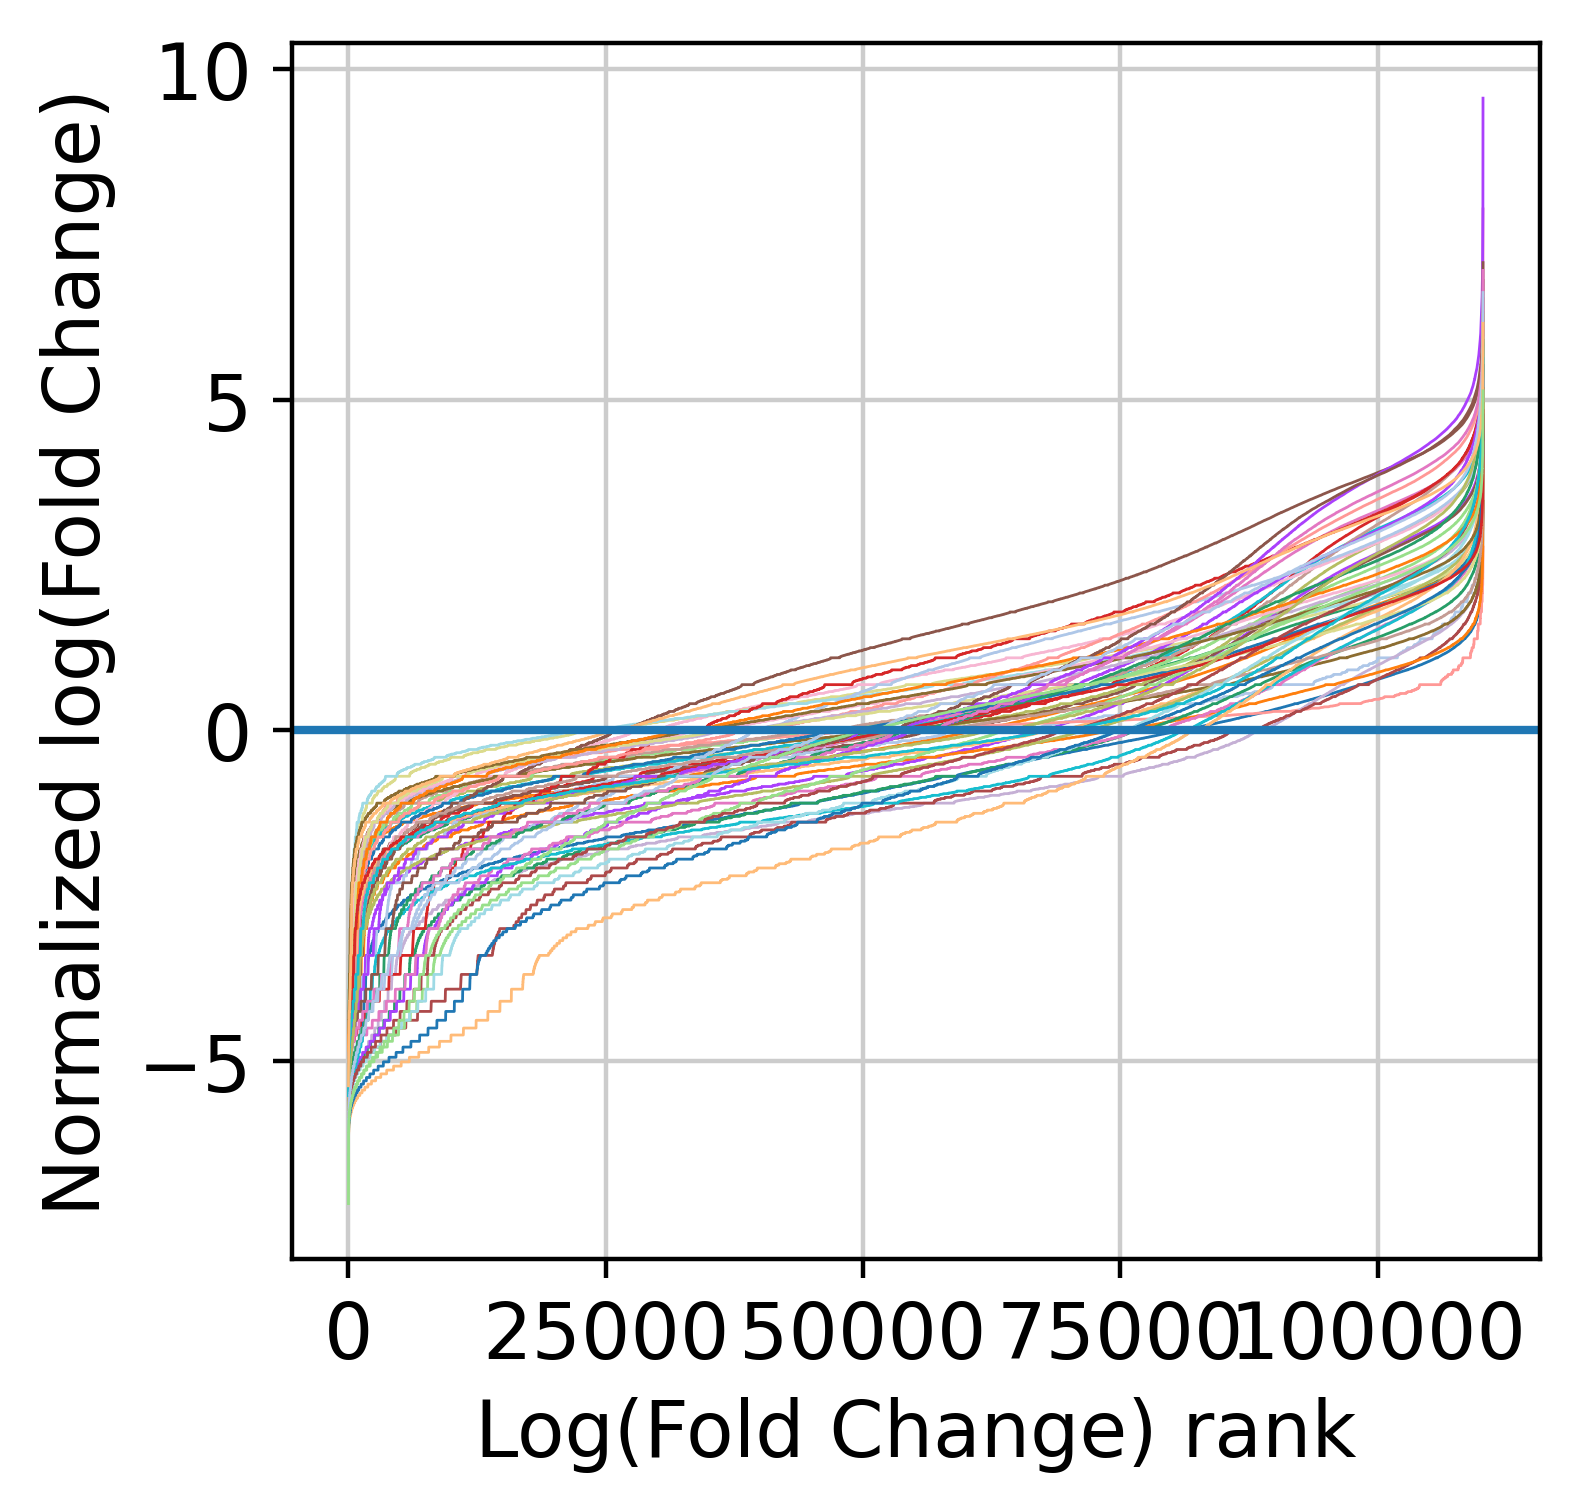

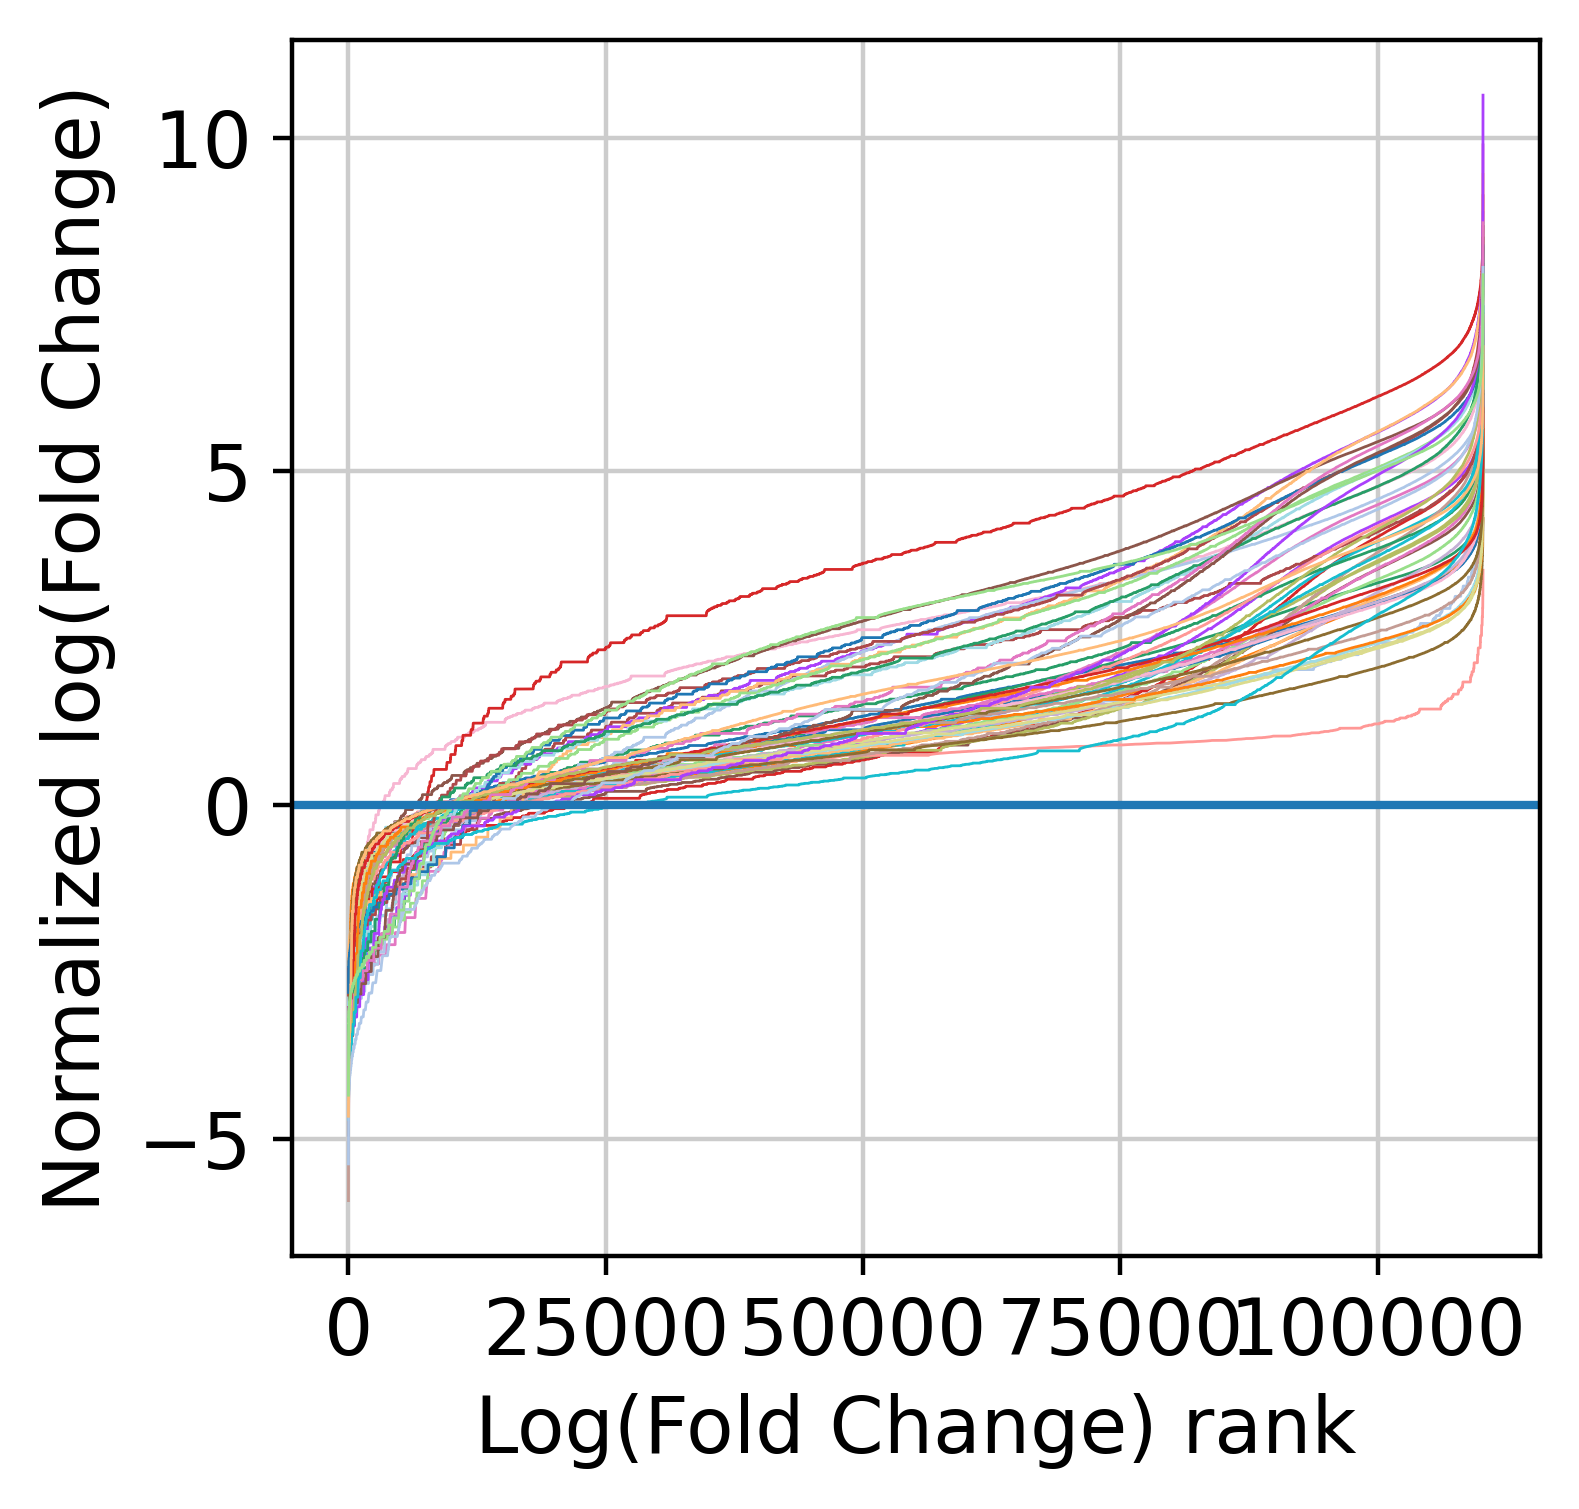

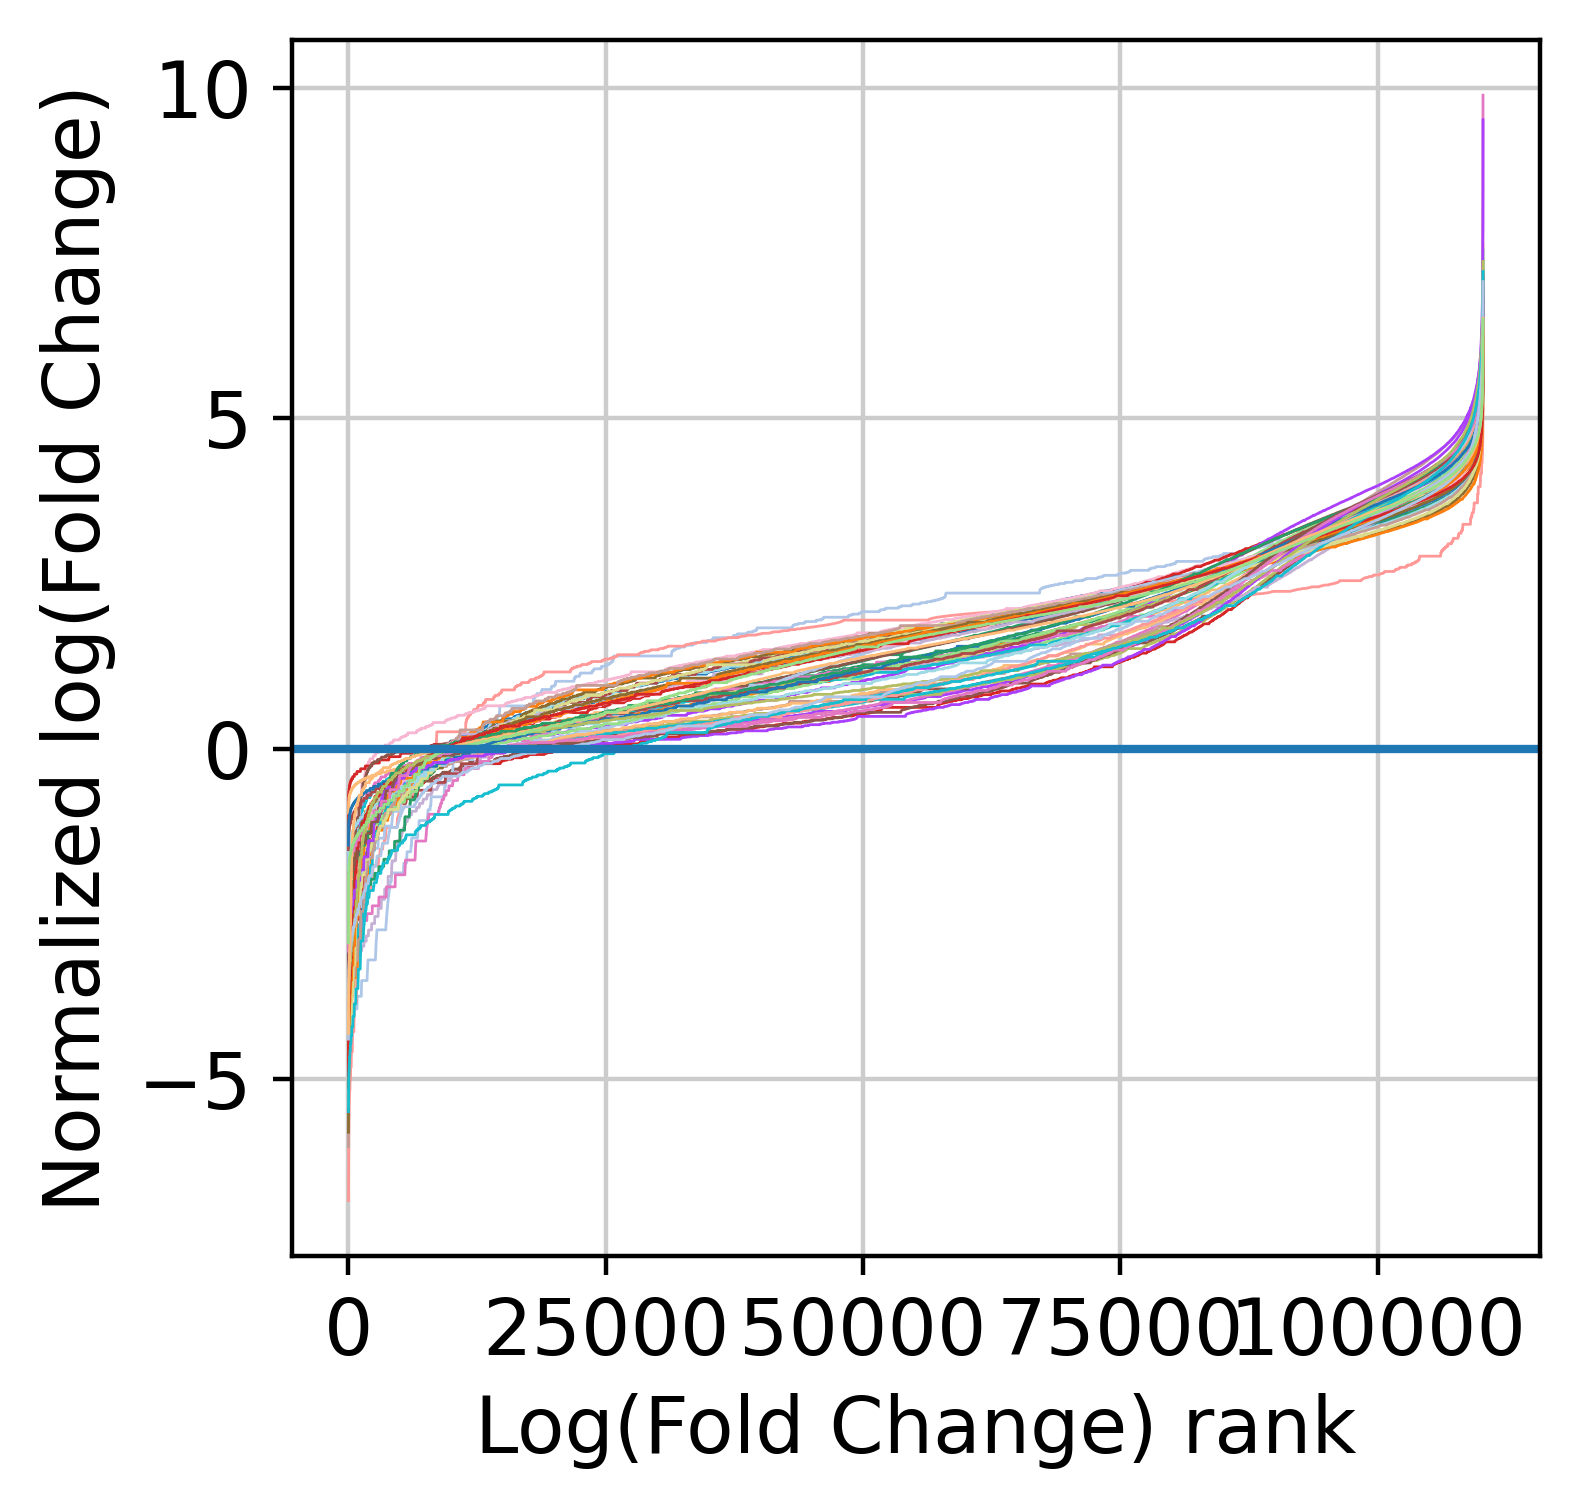

In [10]:
detectable = muffin.tools.trim_low_counts(dataset)
dataset = dataset[:, detectable]
muffin.tools.rescale_input_center_scale(dataset, plot=True)
design = np.concatenate([np.ones((len(dataset),1))], axis=1)
muffin.load.set_design_matrix(dataset, design)

The next step is to fit the mean-variance relationship and the compute residuals to the fitted Negative Binomial model.

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 368 tasks      | elapsed:   38.7s
[Parallel(n_jobs=16)]: Done 2000 out of 2000 | elapsed:   44.9s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:  1.2min
[Parallel(n_jobs=16)]: Done 86048 tasks      | elapsed:  3.7min
[Parallel(n_jobs=16)]: Done 110245 out of 110245 | elapsed:  4.4min finished


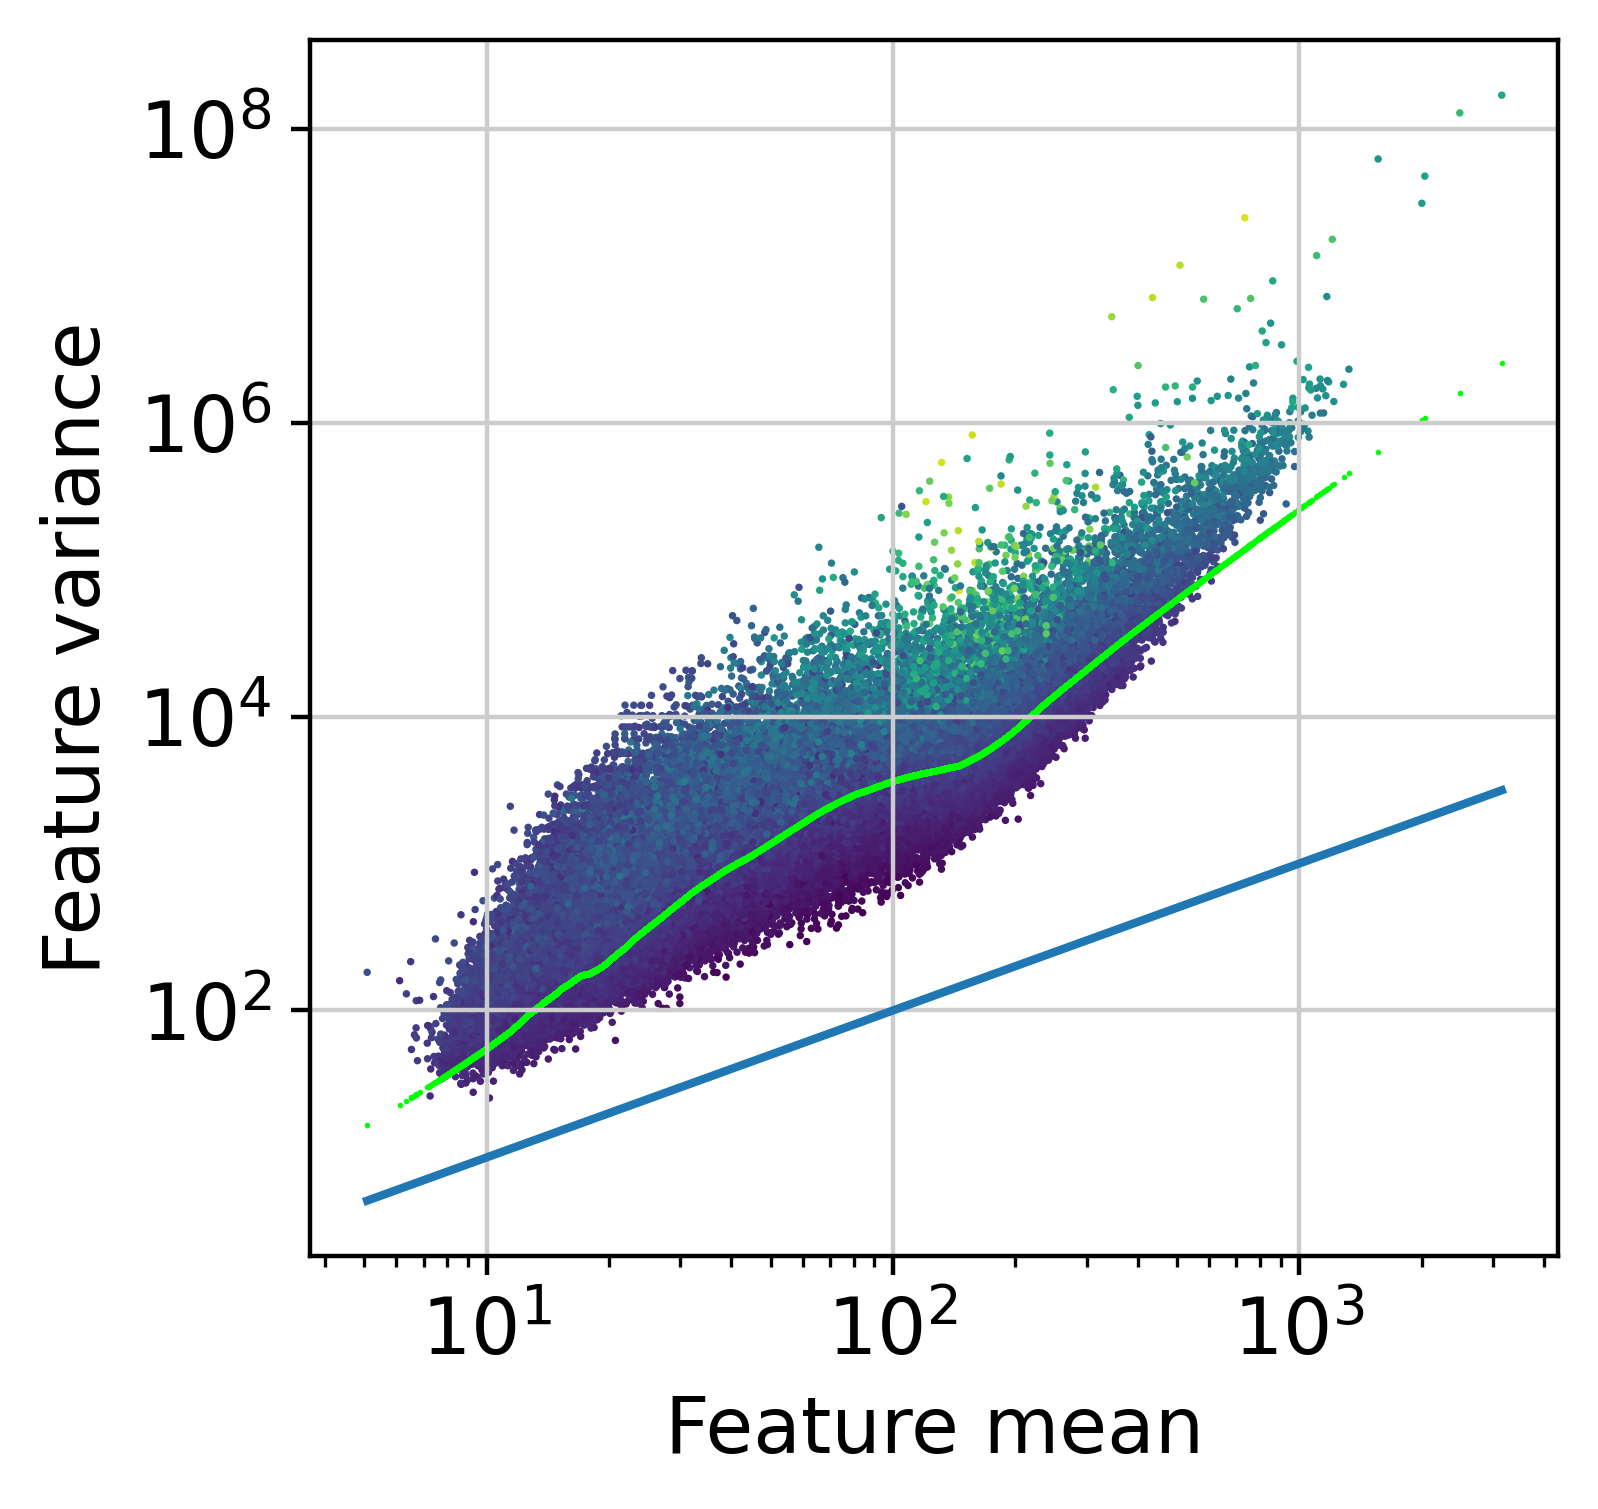

AnnData object with n_obs × n_vars = 52 × 110245
    obs: 'size_factors', 'size_factors_input', 'centered_lfc', 'pi0'
    var: 'Chromosome', 'Start', 'End', 'Strand', 'means', 'variances', 'reg_alpha'
    uns: 'counts_random', 'tot_mapped_counts', 'input_random'
    obsm: 'design'
    layers: 'input', 'normalization_factors', 'residuals'

In [11]:
muffin.tools.compute_residuals(dataset, residuals="quantile", maxThreads=16)

We can perform feature selection to remove peaks with low information. Additionally for ChIP-seq we propose a tool to remove features with insufficient enrichment over input, which can be useful if you use a large catalogue of regions without peak calling. As peak calling was already performed, almost all features are passing this step.

<Figure size 800x800 with 0 Axes>

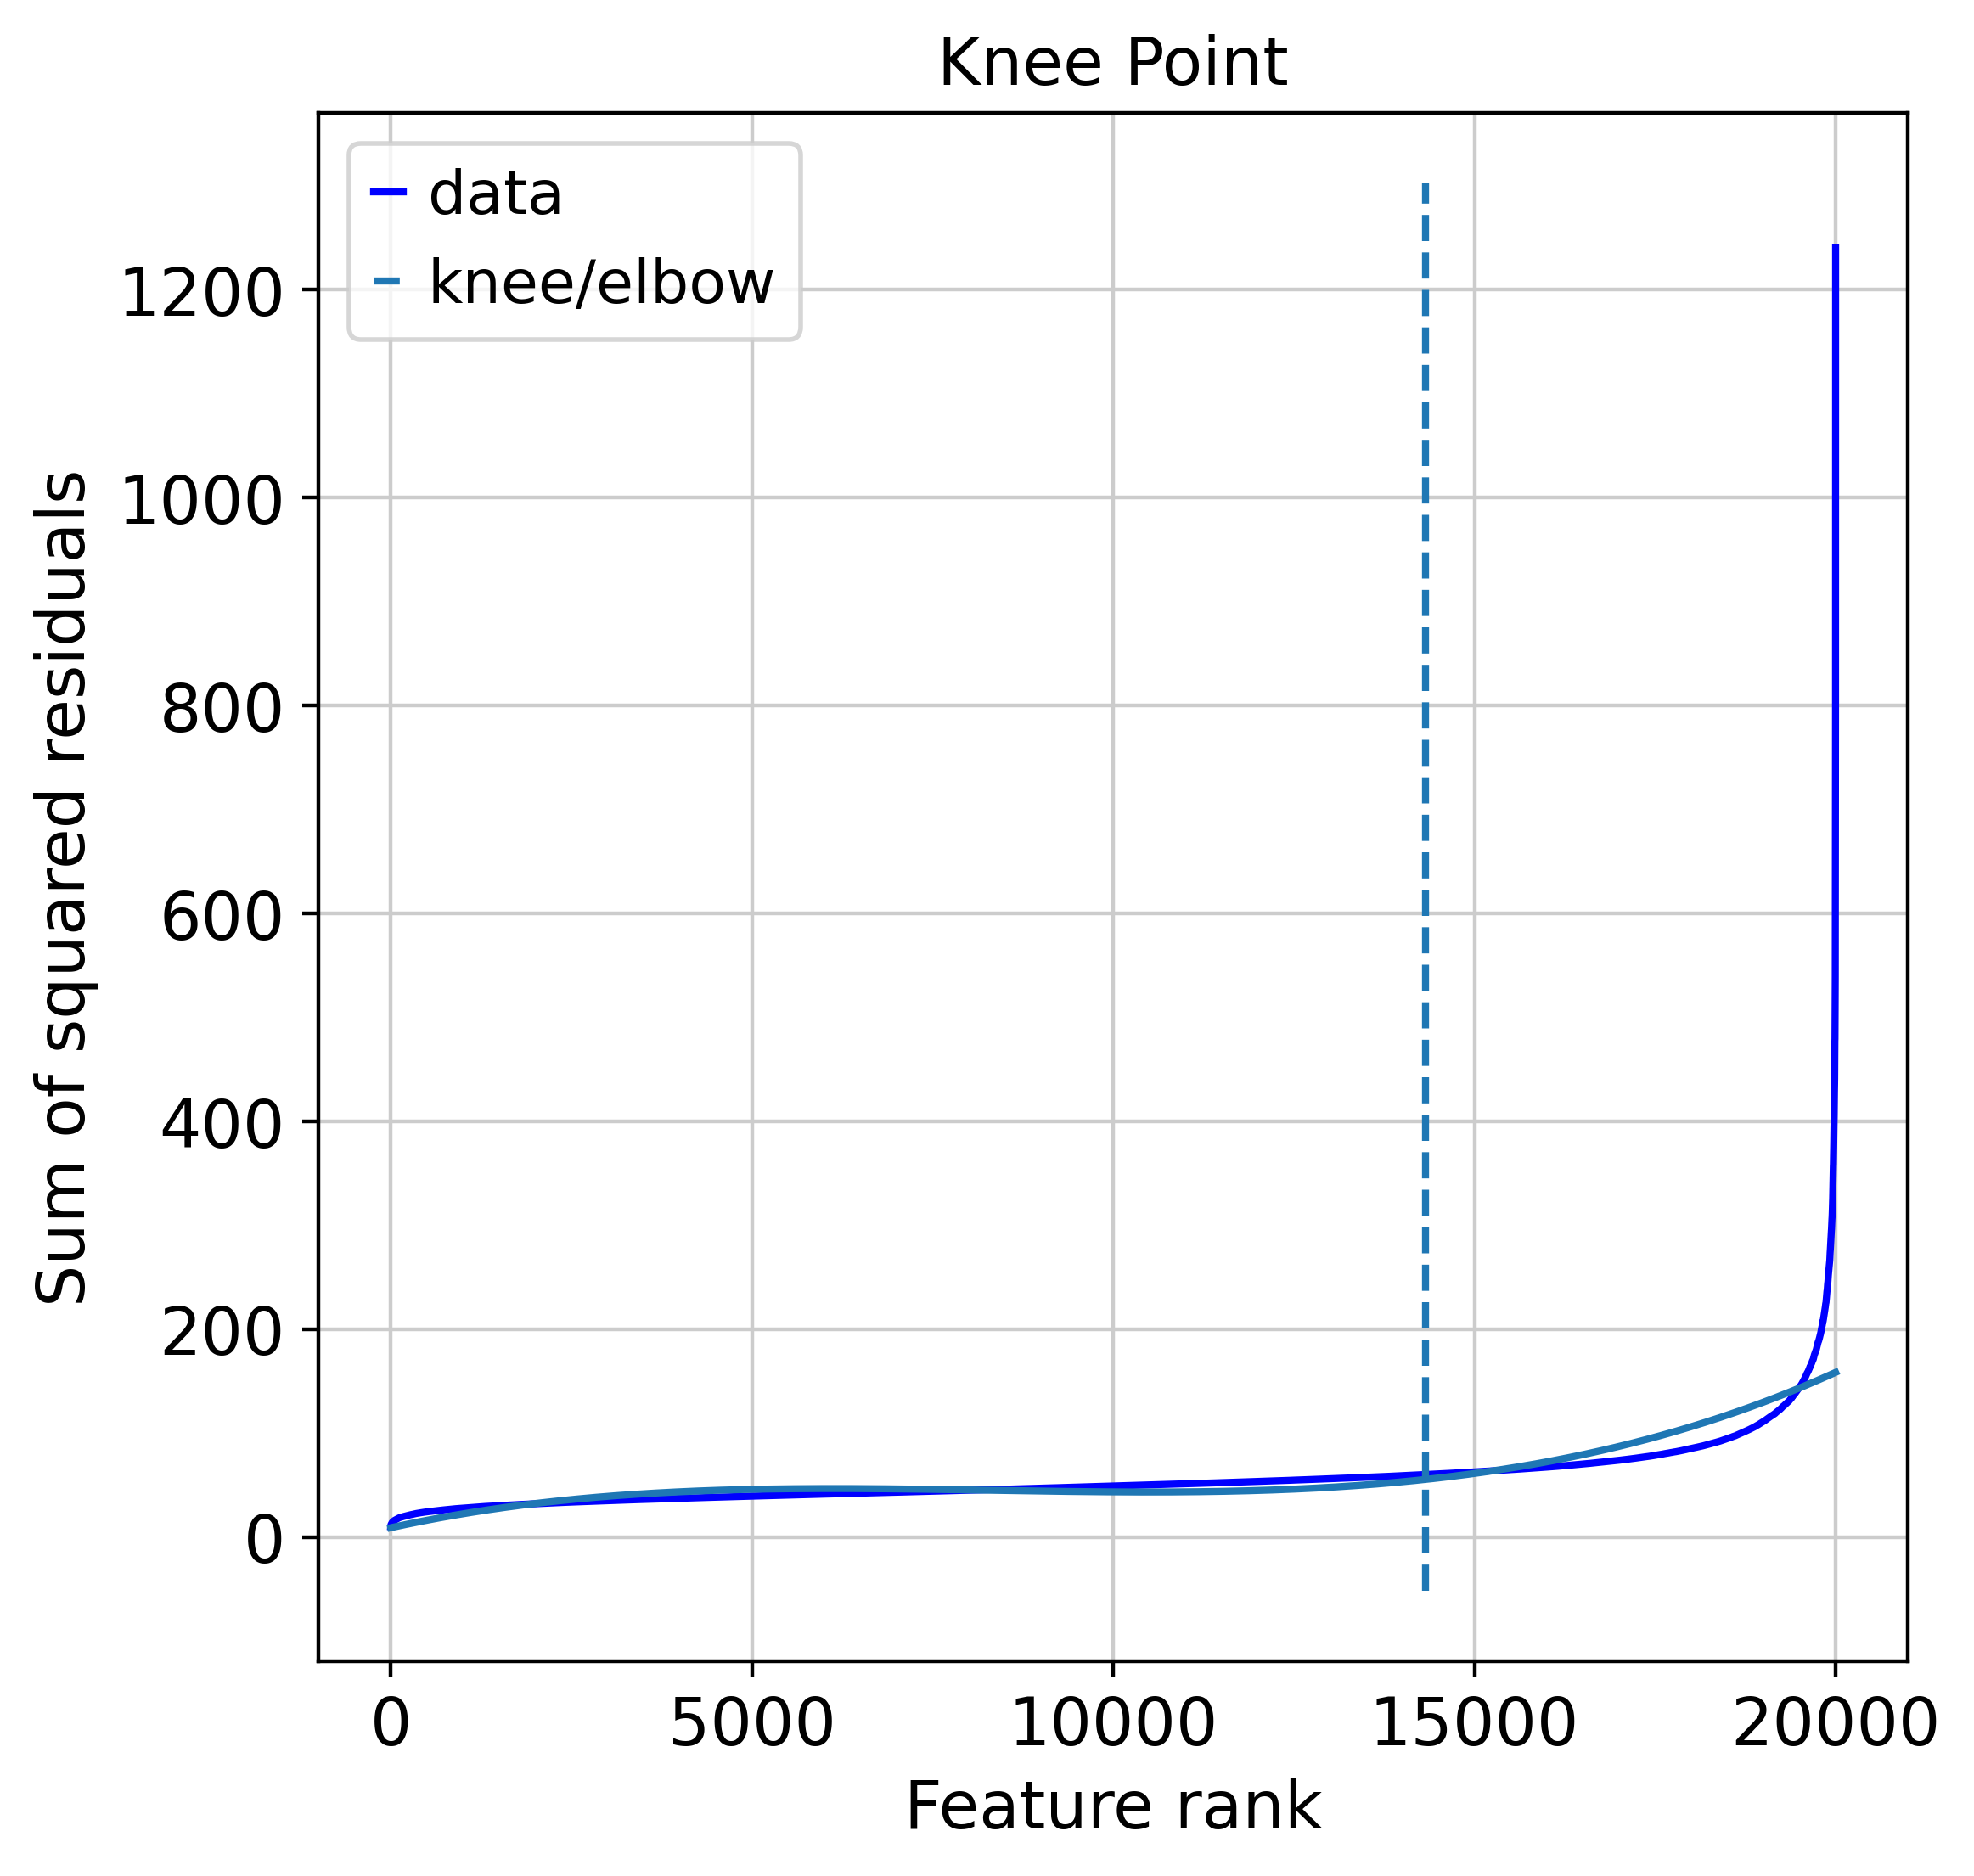

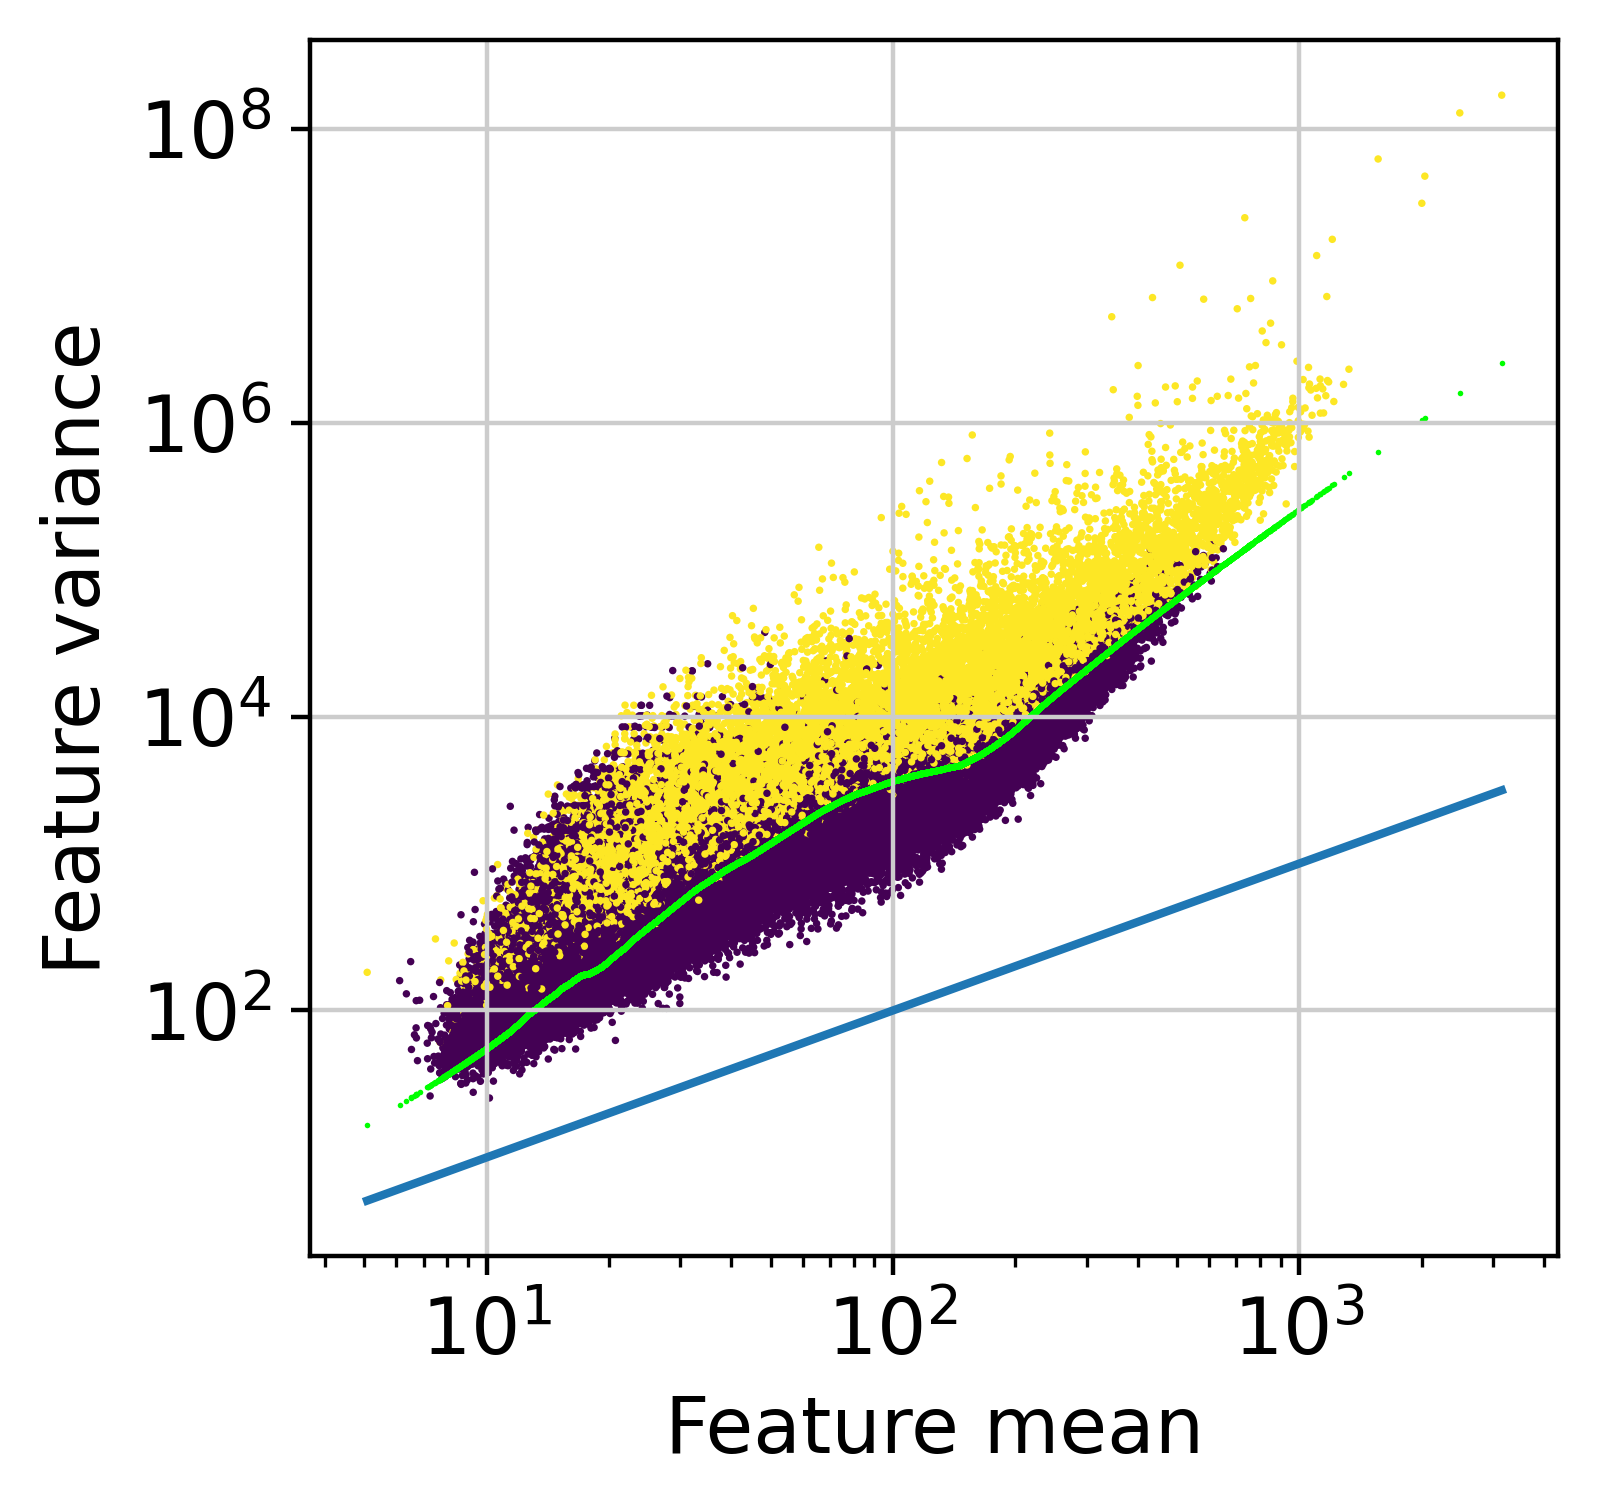

0.9999727878815365


In [12]:
peaks = muffin.tools.pseudo_peak_calling(dataset)
hv = muffin.tools.feature_selection_elbow(dataset)
print(np.mean(peaks))

Next, we perform dimensionnality reduction through with PCA and UMAP.

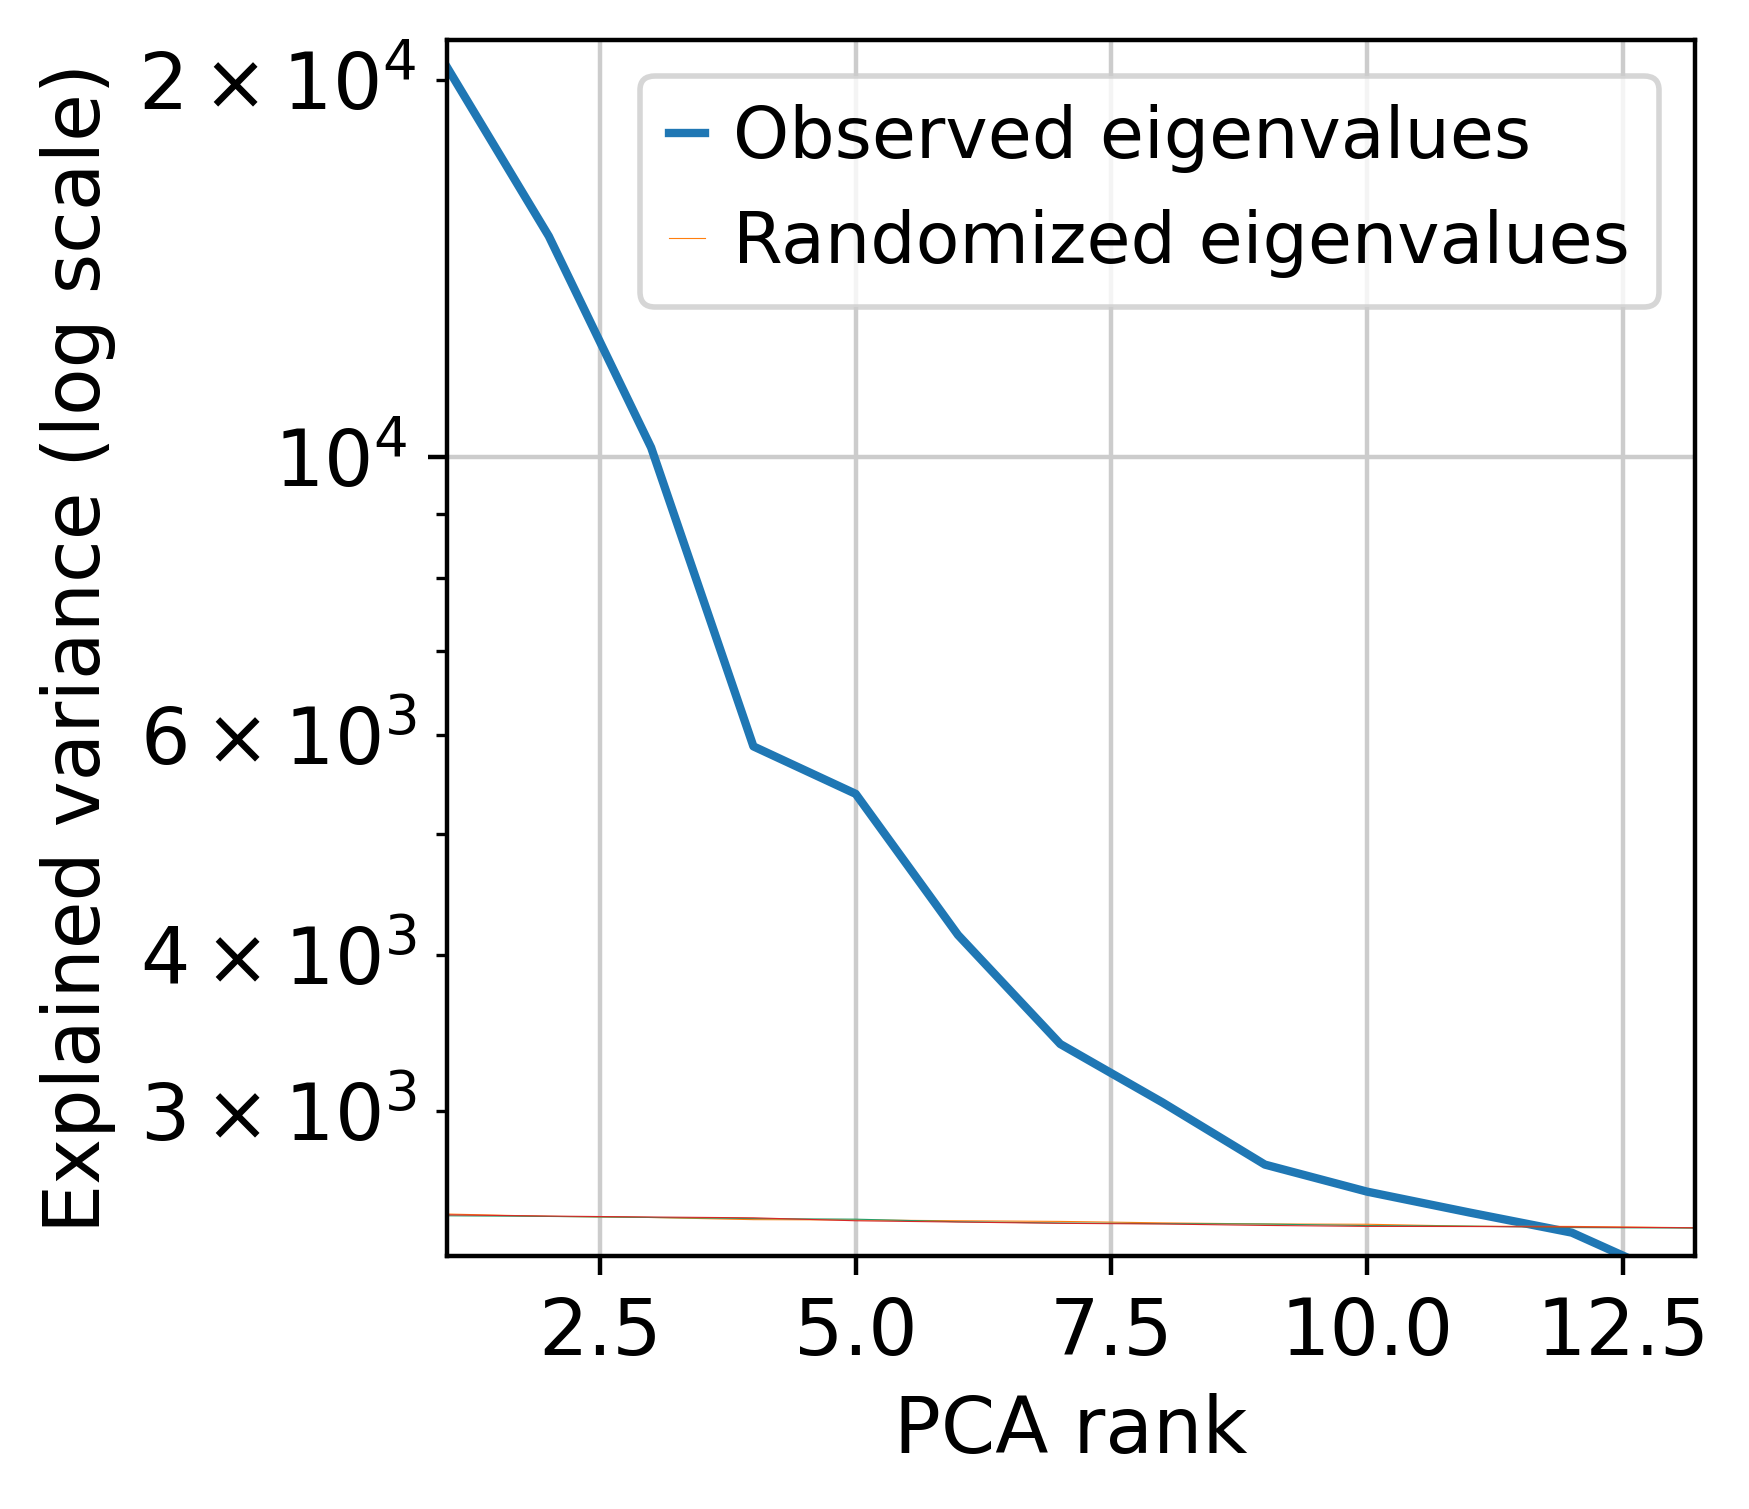

AnnData object with n_obs × n_vars = 52 × 110245
    obs: 'size_factors', 'size_factors_input', 'centered_lfc', 'pi0'
    var: 'Chromosome', 'Start', 'End', 'Strand', 'means', 'variances', 'reg_alpha'
    uns: 'counts_random', 'tot_mapped_counts', 'input_random', 'pca'
    obsm: 'design', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'input', 'normalization_factors', 'residuals'

In [13]:
muffin.tools.compute_pa_pca(dataset, plot=True)
muffin.tools.compute_umap(dataset)

Display the results. Note that we can use scanpy functions here!

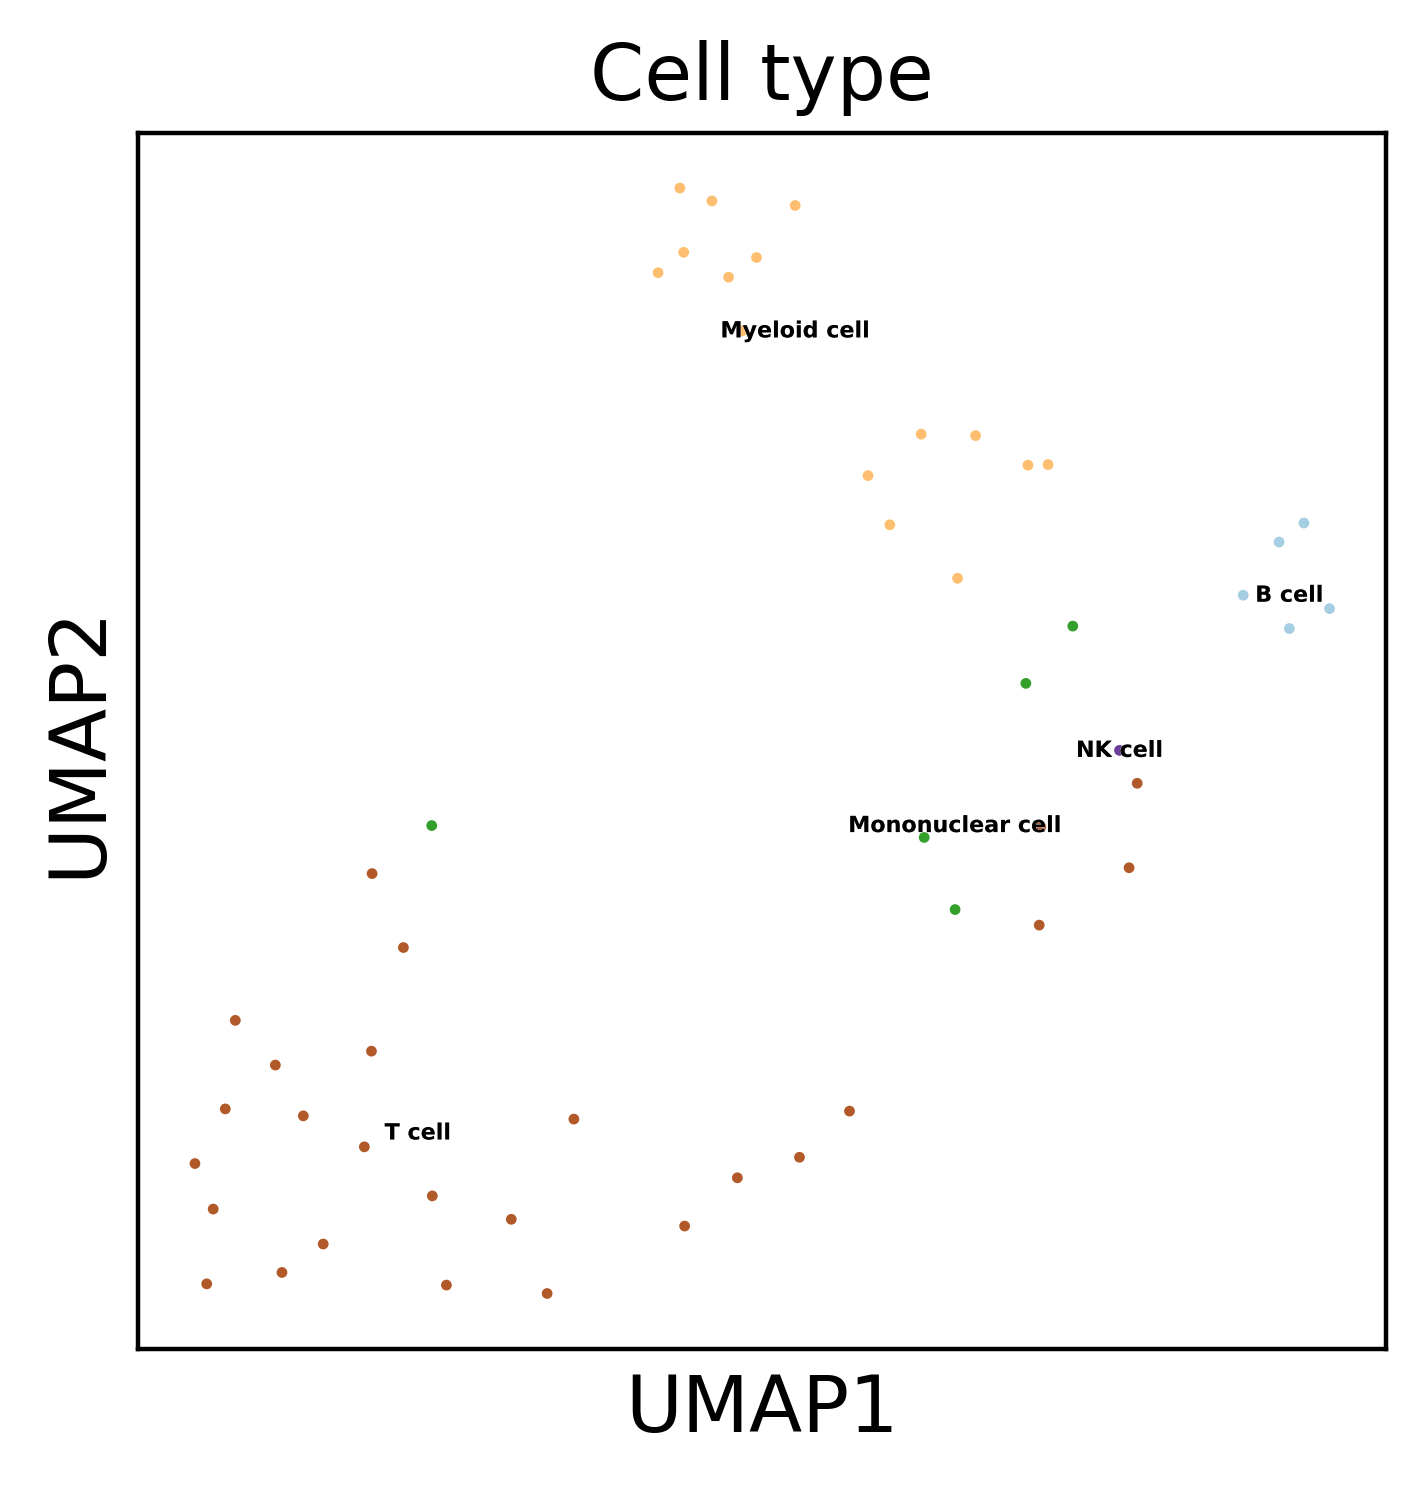

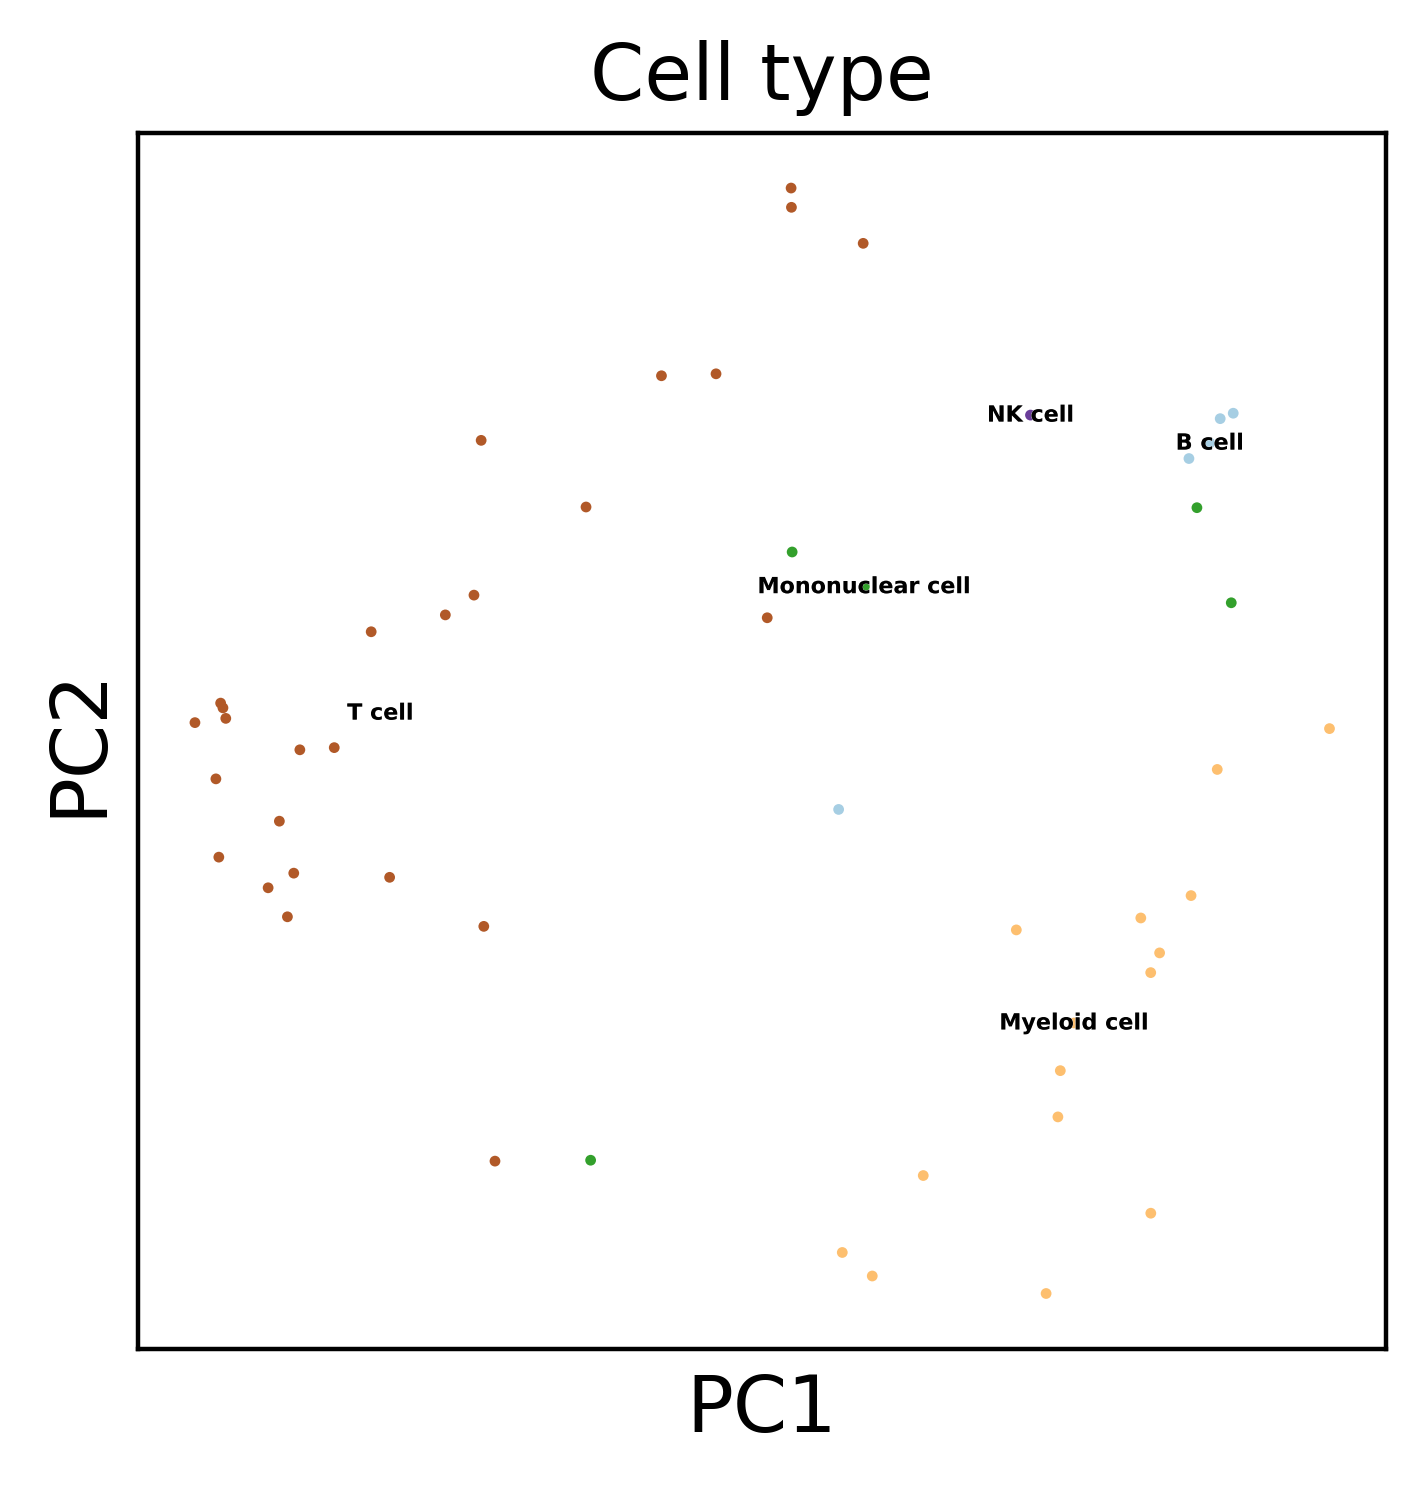

In [14]:
# Append cell type info to the dataset
dataset.obs["Cell type detailed"] = metadata_chip["Biosample term name"].values
dataset.obs["Cell type"] = metadata_chip["Biosample cell type"].values
sc.pl.umap(dataset, color='Cell type', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='Paired')
sc.pl.pca(dataset, color='Cell type', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='Paired')

We can also use heatmaps, even if we have a large number of features :

31290


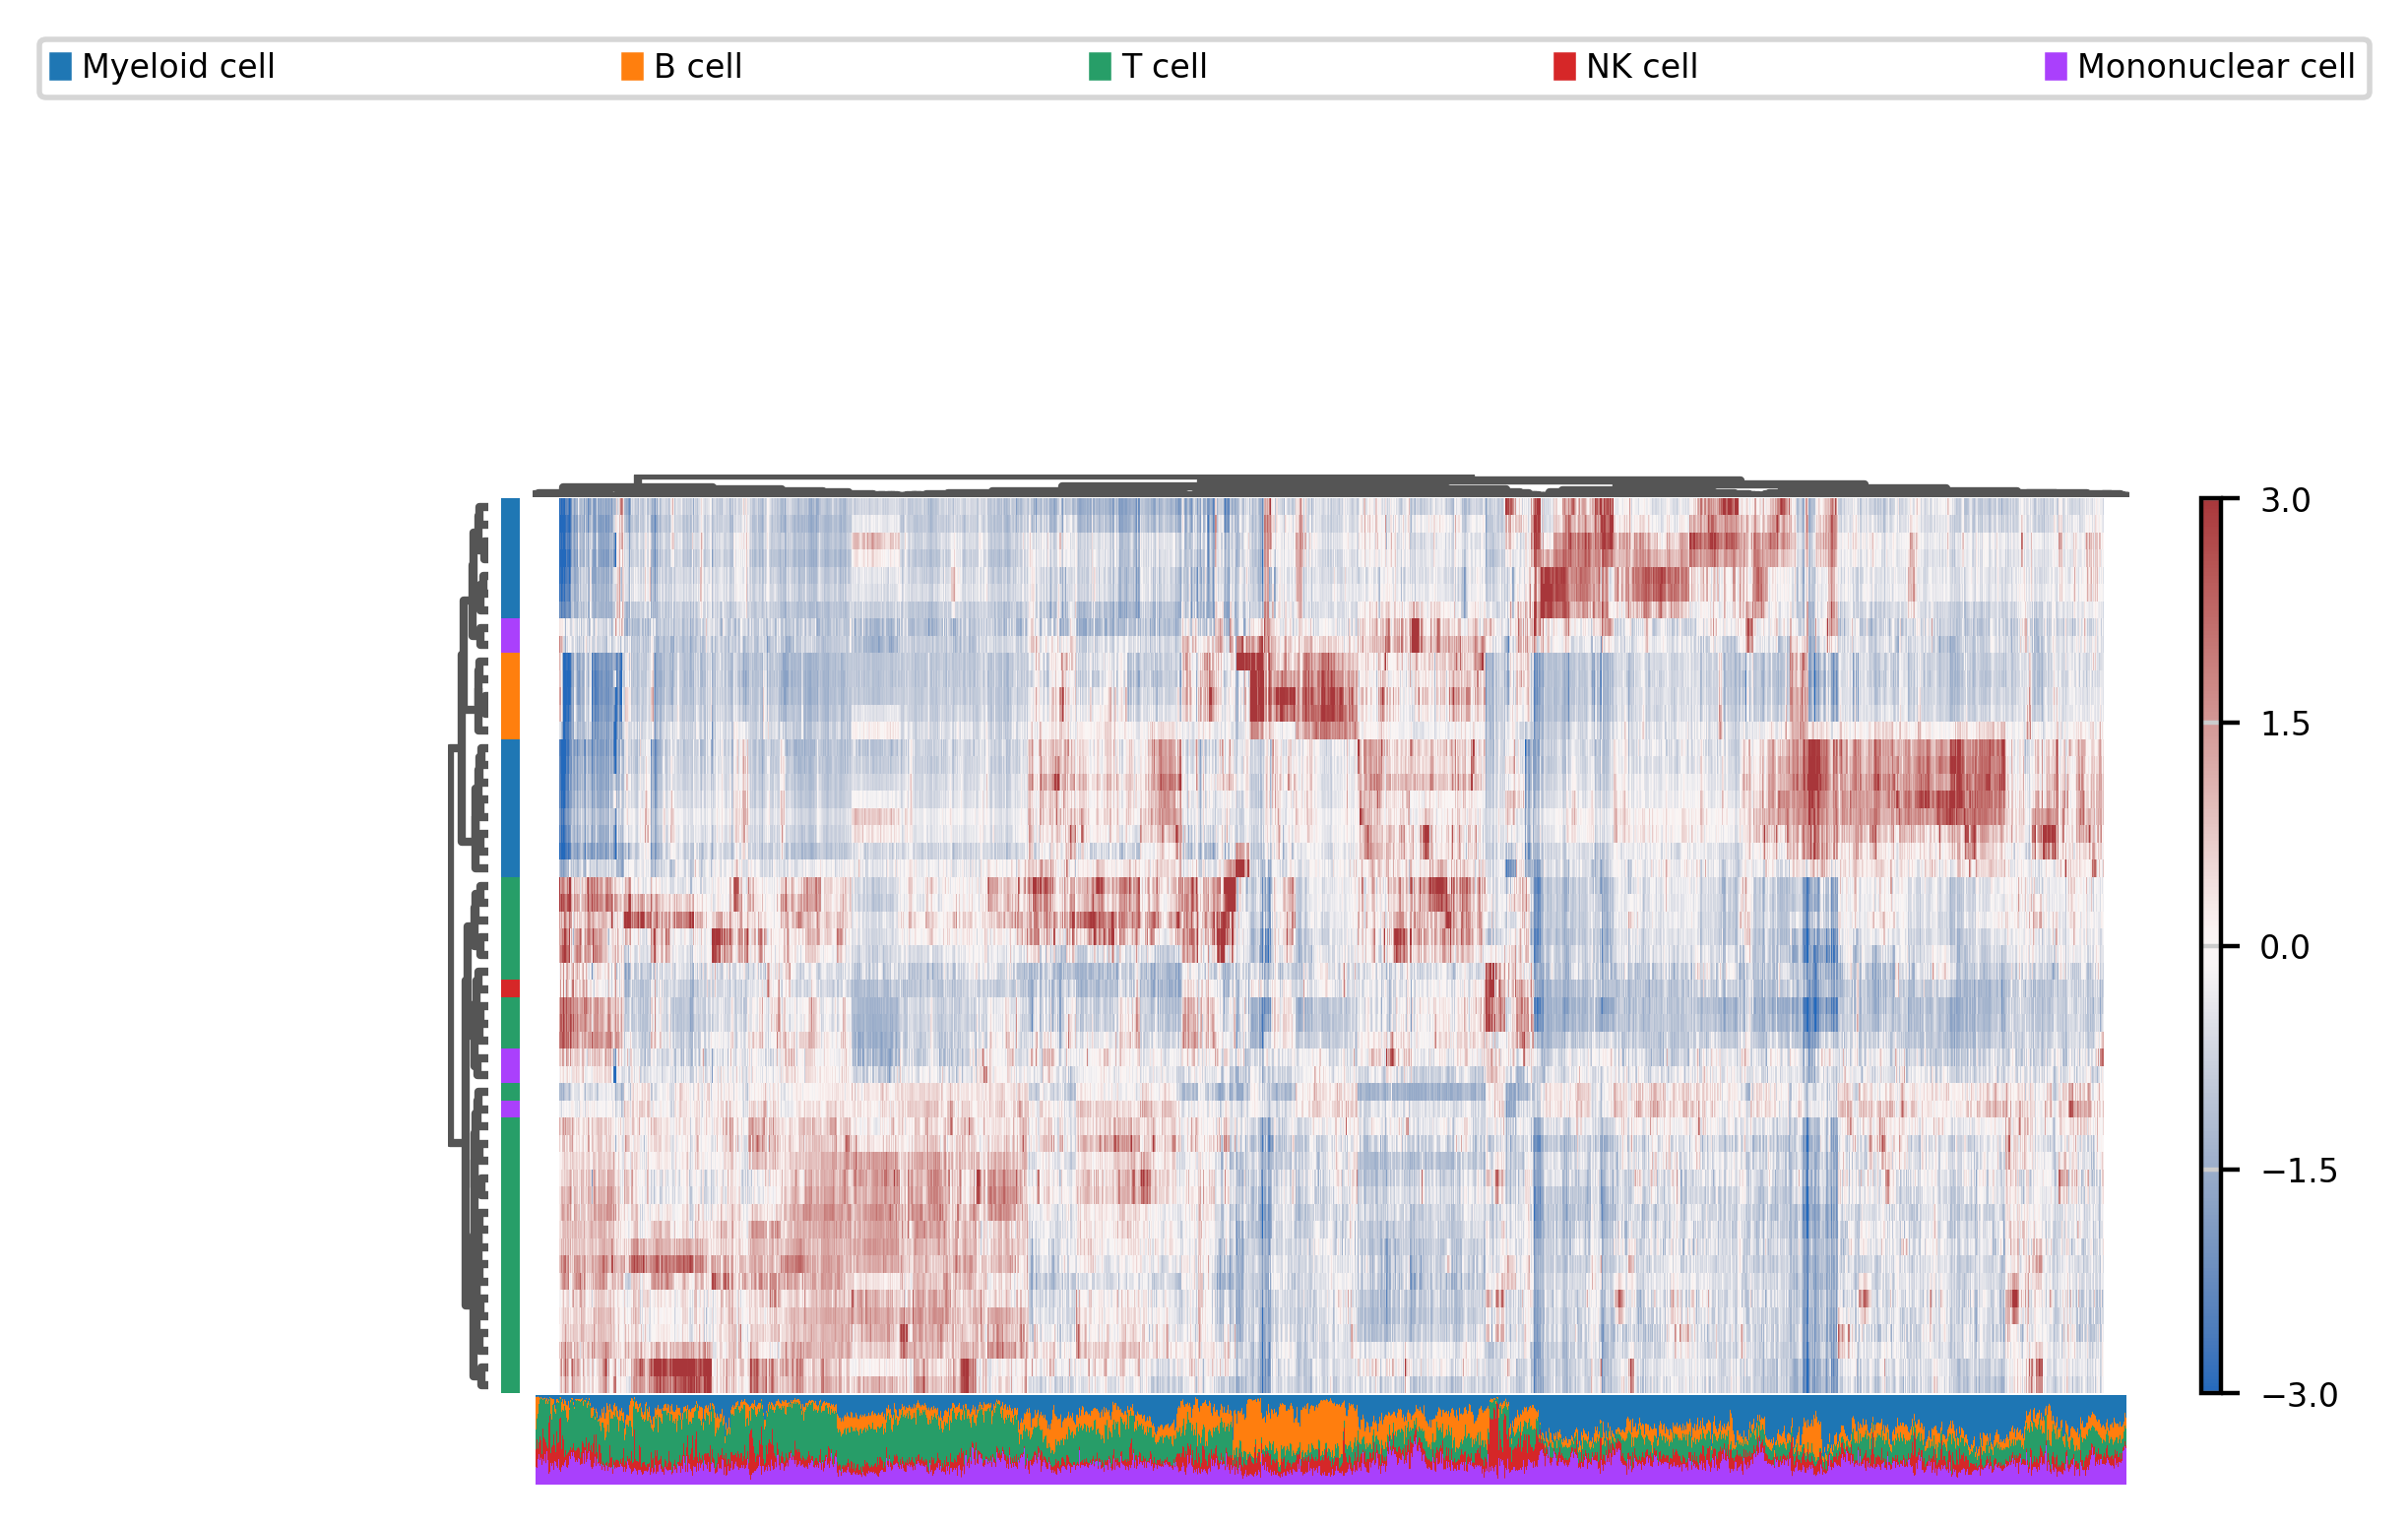

In [15]:
print((peaks & hv).sum())
fig, ax = muffin.plots.mega_heatmap(dataset[:, hv&peaks], layer="residuals", label_col="Cell type", vmin=-3, vmax=3)

Let's find the differentially bound regions between T-cells and B-cells:

In [16]:
# First subset our dataset
selected = dataset[(dataset.obs["Cell type"] == "B cell") | (dataset.obs["Cell type"] == "T cell")]
muffin.tools.differential_expression_A_vs_B(selected, category="Cell type", 
                                        ref_category="T cell")


Comparing B cell to (reference) T cell
Using DESeq2 with normalization factors per row, per gene


R[write to console]: using pre-existing normalization factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1157 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



Let's have a first look at the best markers between B and T cells :

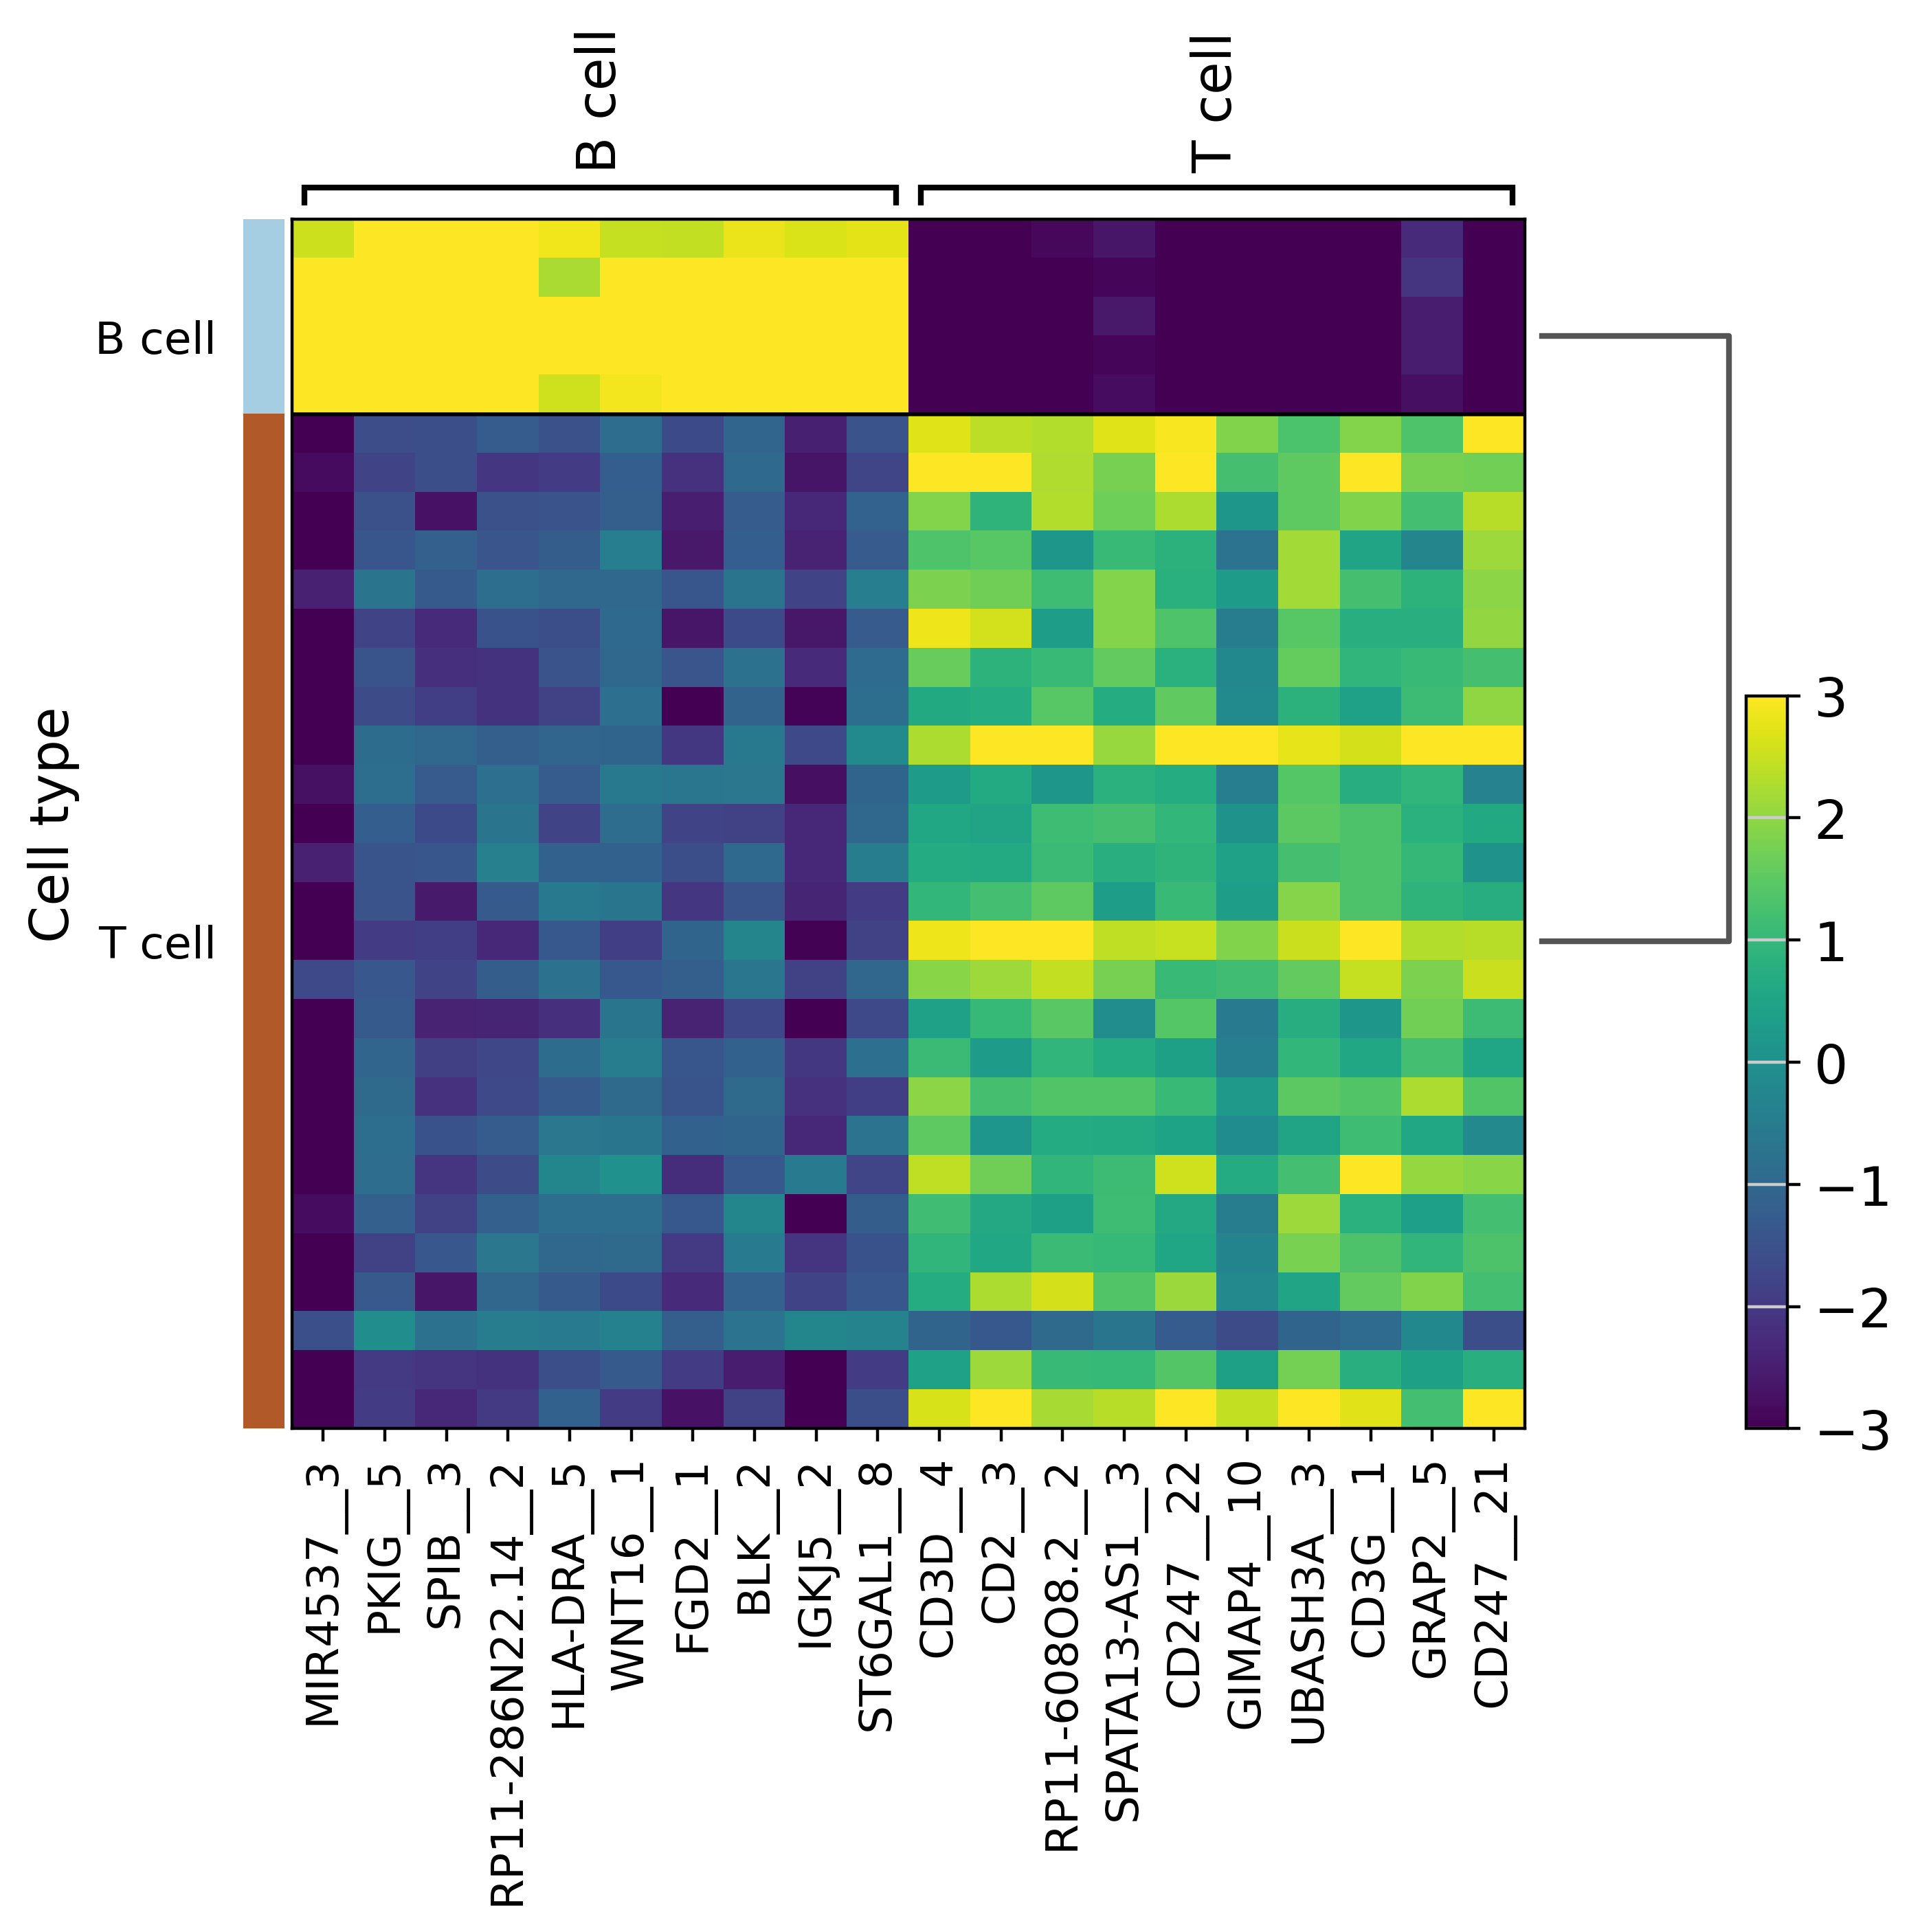

z-score  log2FoldChange        pvalue          padj
MIR4537__3         16.433373        5.351551  1.103468e-60  1.113311e-55
PKIG__5            16.050466        4.654333  5.673613e-58  2.862111e-53
SPIB__3            15.372901        4.865741  2.487759e-53  8.366498e-49
RP11-286N22.14__2  14.659720        4.785894  1.167530e-48  2.944861e-44
HLA-DRA__5         14.638806        3.962513  1.588322e-48  3.204979e-44
...                      ...             ...           ...           ...
TFEC__1            -0.631995       -0.242962  5.273903e-01  1.000000e+00
IGFBP4__2                NaN        1.195152           NaN  1.000000e+00
TFEC__4             0.763987        0.311671  4.448748e-01  1.000000e+00
RP11-109A6.2__1    -0.988146       -0.394602  3.230813e-01  1.000000e+00
DDX11L1__1          0.164114        0.114402  8.696418e-01  1.000000e+00

[110245 rows x 4 columns]

In [17]:
sc.pl.rank_genes_groups_heatmap(selected,layer="residuals", 
                                use_raw=False, vmin=-3, vmax=3, 
                                cmap='viridis')
selected.varm["DE_results"].sort_values("padj")


We can already see genes specific to T cells (CD3E, CD3D...) and some specific to B cells (BLNK, BLK...). We can go further and perform a Genomic Regions Enrichment Analysis to get a GSEA of nearby genes.

In [18]:
# Retrieve DE regions
DE_indexes = (selected.varm["DE_results"]["padj"] < 0.05) & (np.abs(selected.varm["DE_results"]["log2FoldChange"]) > 1.0)
all_regions = selected.var[["Chromosome", "Start", "End"]]
query = all_regions[DE_indexes]
# Perform GREA
gsea_results = gsea_obj.find_enriched(query, all_regions, cores=16)
gsea_results

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 2516 tasks      | elapsed:  5.2min
[Parallel(n_jobs=16)]: Done 8216 tasks      | elapsed: 10.2min
[Parallel(n_jobs=16)]: Done 8813 out of 8813 | elapsed: 10.8min finished


P(Beta > 0)      Beta  Total hits  BH corrected p-value  \
0                                                                      
GO:0002250  6.971654e-48  0.562758        1963          6.144119e-44   
GO:0046649  1.884302e-18  0.293050        2666          8.303178e-15   
GO:0042110  2.199839e-16  0.321682        2078          5.551631e-13   
GO:0045321  2.519747e-16  0.254236        2959          5.551631e-13   
GO:0002684  7.413552e-16  0.248544        2821          1.306713e-12   
...                  ...       ...         ...                   ...   
GO:0051301  9.999955e-01 -0.214479         716          9.999983e-01   
GO:0019752  9.999957e-01 -0.189734         949          9.999983e-01   
GO:0043436  9.999980e-01 -0.194738         964          9.999983e-01   
GO:0070925  9.999982e-01 -0.189735        1025          9.999983e-01   
GO:0007017  9.999983e-01 -0.197020         907          9.999983e-01   

            -log10(qval)  -log10(pval)        FC  \
0                                                  
GO:0002250  4.321154e+01  4.715666e+01  1.755508   
GO:0046649  1.408076e+01  1.772485e+01  1.340509   
GO:0042110  1.225558e+01  1.565761e+01  1.379447   
GO:0045321  1.225558e+01  1.559864e+01  1.289475   
GO:0002684  1.188382e+01  1.512997e+01  1.282157   
...                  ...           ...       ...   
GO:0051301  7.410858e-07  1.961061e-06  0.806962   
GO:0019752  7.410858e-07  1.886755e-06  0.827179   
GO:0043436  7.410858e-07  8.733082e-07  0.823050   
GO:0070925  7.410858e-07  7.634767e-07  0.827179   
GO:0007017  7.410858e-07  7.410858e-07  0.821175   

                                                    Name  
0                                                         
GO:0002250                      adaptive immune response  
GO:0046649                         lymphocyte activation  
GO:0042110                             T cell activation  
GO:0045321                          leukocyte activation  
GO:0002684  positive regulation of immune system process  
...                                                  ...  
GO:0051301                                 cell division  
GO:0019752             carboxylic acid metabolic process  
GO:0043436                     oxoacid metabolic process  
GO:0070925                            organelle assembly  
GO:0007017                     microtubule-based process  

[8813 rows x 8 columns]

We do observe an enrichment of immune and T/B Cells related terms.

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning:

Data was converted to boolean for metric yule

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/great.py:605: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/great.py:608: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages

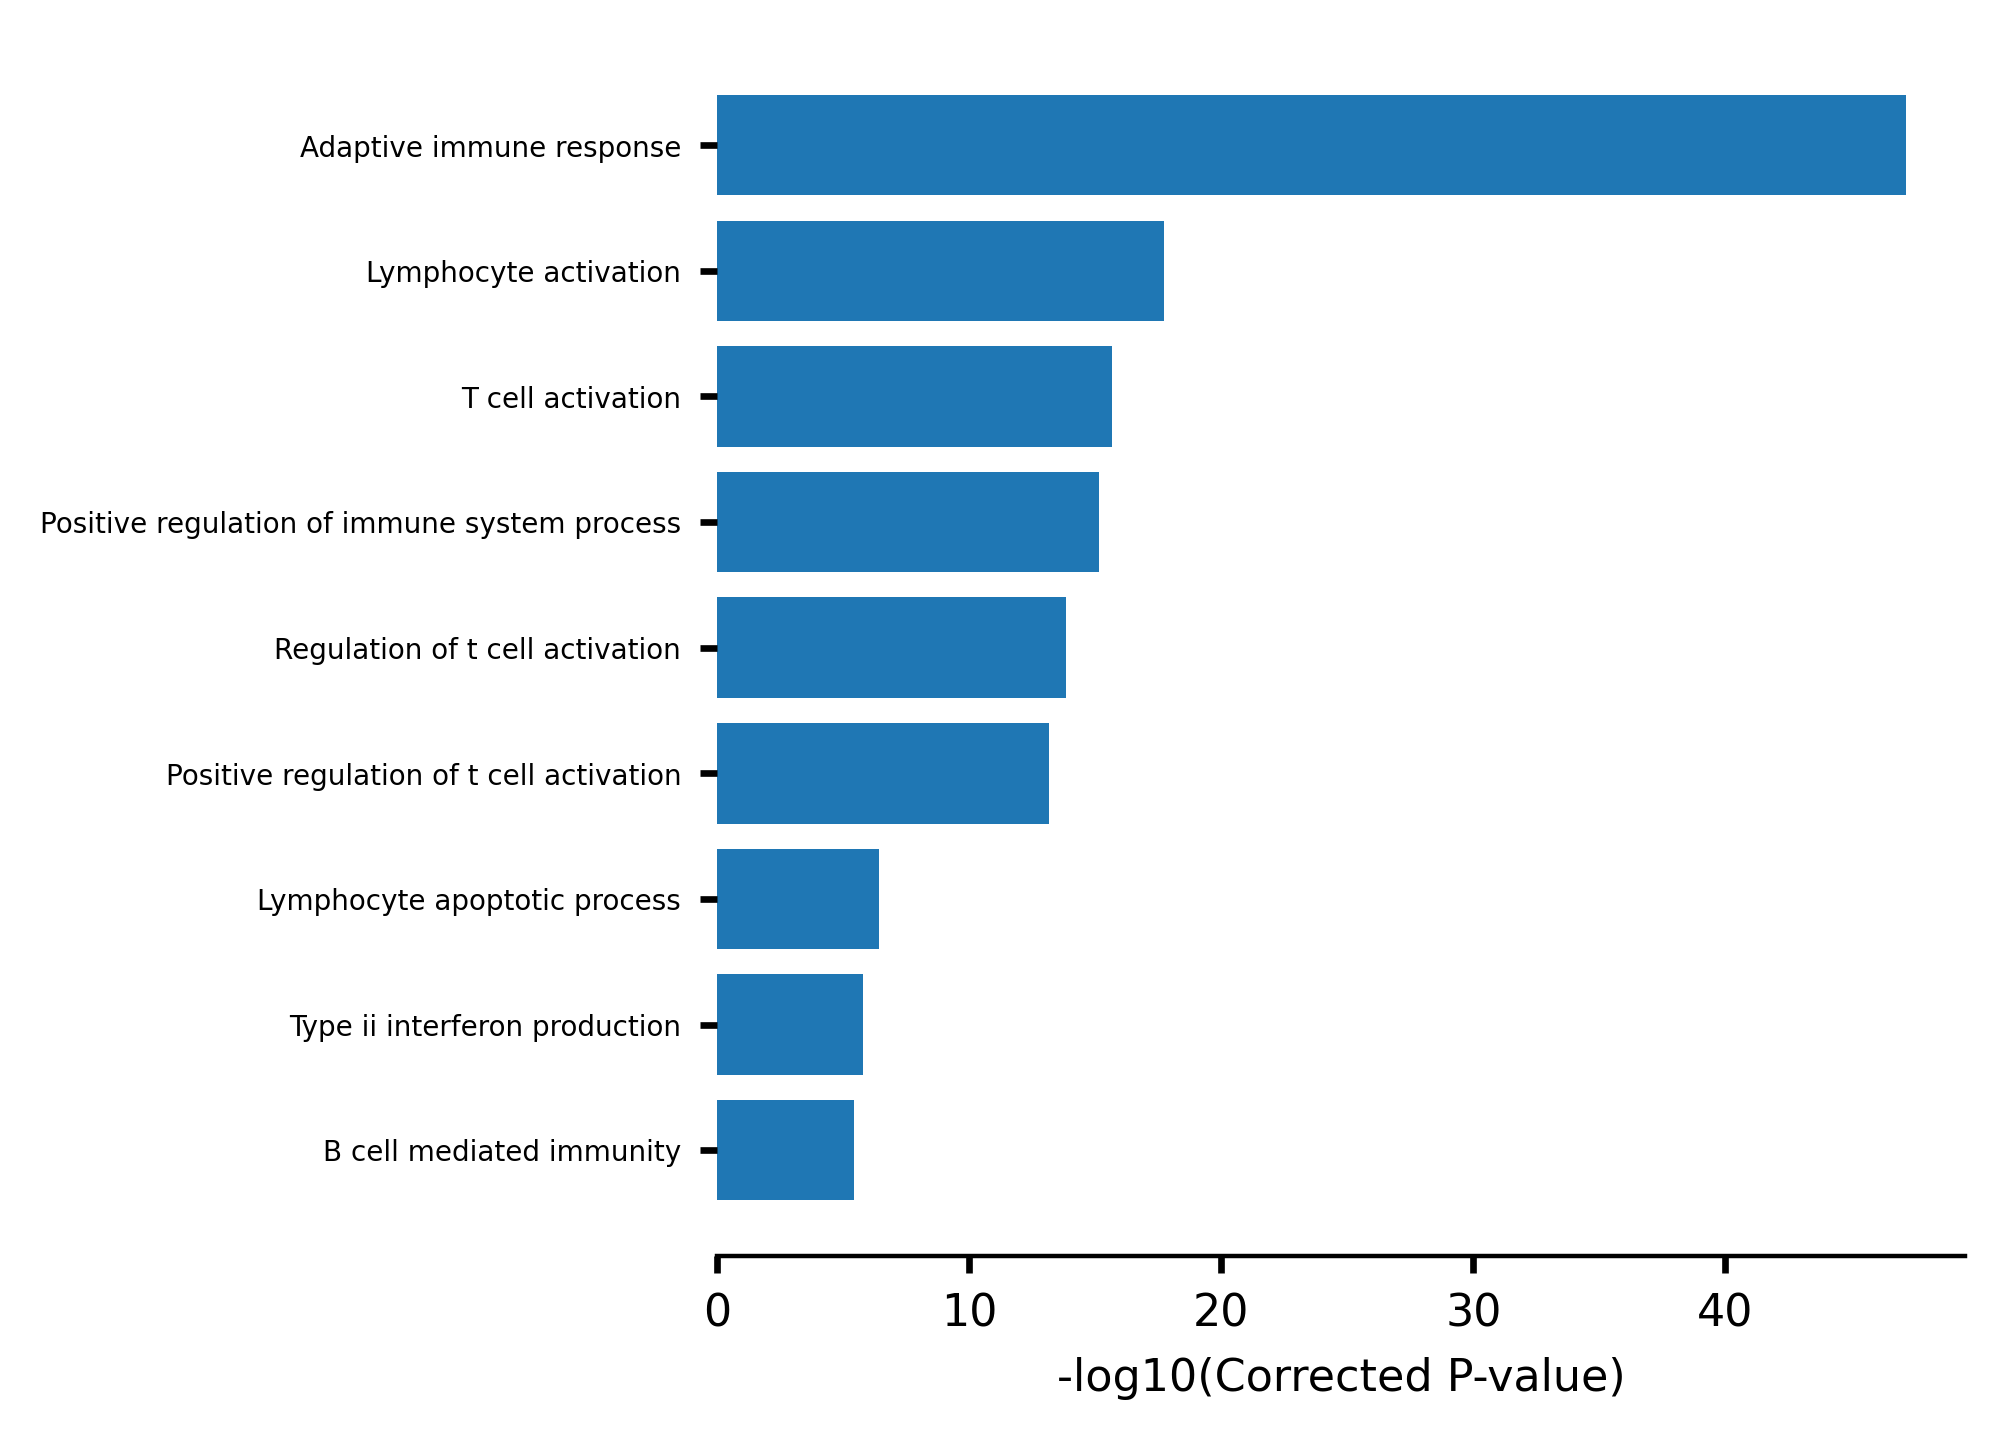

In [19]:
import plotly.offline as pyo
pyo.init_notebook_mode()
gsea_clusters = gsea_obj.cluster_treemap(gsea_results, output="h3k4me3_results/cluster_treemap.pdf")
fig, ax = gsea_obj.barplot_enrich(gsea_clusters)
fig.savefig("h3k4me3_results/barplot_enrich.pdf", bbox_inches="tight")

We can save our work to avoid recomputing everything. It can easily be re-loaded using :  anndata.read_h5ad(path)

In [20]:
dataset.write("h3k4me3_results/dataset.h5ad")